In [1]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from linage import get_lineage_coll
from resistance import get_resistance_snp

In [13]:
def import_VCF4_to_pandas(vcf_file, sep='\t'):
    with open(vcf_file) as f:
        first_line = f.readline().strip()
    if first_line.endswith('VCFv4.0'):
        #Use first line as header
        dataframe = pd.read_csv(vcf_file, sep=sep, skiprows=[16], header=16)
        dataframe[['DP', 'AF', 'SB', 'DP4']] = dataframe['INFO'].str.split(r';.{1,3}=', expand=True)
        dataframe.DP = dataframe.DP.str.split('=').str[1]
        """
        DF4 = Number of :
        1) forward ref alleles; 
        2) reverse ref; 
        3) forward non-ref; 
        4) reverse non-ref alleles, used in variant calling. 
        Sum can be smaller than DP because low-quality bases are not counted.
        """
        dataframe[['Fref', 'Rref', 'Fsample', 'Rsample']] = dataframe['DP4'].str.split(',', expand=True)
        dataframe[['DP', 'AF', 'SB','Fref', 'Rref', 'Fsample', 'Rsample']] = dataframe[['DP', 'AF', 'SB','Fref', 'Rref', 'Fsample', 'Rsample']].astype(float)
    return dataframe

def replace_nucleotide(list_fasta, postition, nucleotide):
    list_fasta[postition] = nucleotide

#def replace_fasta_sequence(fasta, Nref, Nalt, position)


def replace_fasta_sequence(fasta, Nref_list, Nalt_list, position):
    
    fasta_to_replace = SeqIO.read(fasta,"fasta")
    sequence_to_replace = fasta_to_replace.seq
    sequence_list = list(sequence_to_replace)
    
    for index in range (len(position)):

        nucleotide_list = ['A','T','C','G']
        
        Nref = Nref_list[index]
        Nalt = Nalt_list[index]
    
        if Nref in nucleotide_list:
            nucleotide_list.remove(Nref)
        if Nalt in nucleotide_list:
            nucleotide_list.remove(Nalt)
        
        
        base_to_replace_with = nucleotide_list[0]

        
        sequence_list[position[index] - 1] = base_to_replace_with
        
    return "".join(sequence_list)
    #print(record_to_chop.seq[0:4])

def import_to_pandas(file_table, header=False, sep='\t'):
    if header == False:
        #exclude first line, exclusive for vcf outputted by PipelineTB
        dataframe = pd.read_csv(file_table, sep=sep, skiprows=[0], header=None)
    else:
        #Use first line as header
        dataframe = pd.read_csv(file_table, sep=sep, header=0)
    
    return dataframe

def import_snp_to_pandas(file_table, header=False, sep='\t'):
    #Use first line as header
    dataframe = pd.read_csv(file_table, sep=sep, header=0)
    dataframe.rename(columns={'Position':'POS', 'ref':'REF','Cons':'ALT'}, inplace=True)
    dataframe['AF'] = dataframe['VarFreq'].str.rstrip('%').astype(float)/100
    
    return dataframe

In [14]:
vcf_P150='data/PAIR1_50_50_final.bam.snp.final'
p150_df = import_snp_to_pandas(vcf_P150)

In [15]:
p150_df.head()

Chrom   POS Ref Cons  Reads1  Reads2 VarFreq  Strands1  Strands2  Qual1  \
0  MTB_anc  2532   C    T       0     125    100%         0         2      0   
1  MTB_anc  6140   G    T     102      46  31.08%         2         2     43   
2  MTB_anc  7585   C    G      16      38  70.37%         2         2     43   
3  MTB_anc  9143   C    T       0      84    100%         0         2      0   
4  MTB_anc  9304   A    G      38      63  62.38%         2         2     44   

   Qual2  Pvalue  MapQual1  MapQual2  Reads1Plus  Reads1Minus  Reads2Plus  \
0     45    0.98         0         1           0            0          82   
1     46    0.98         1         1          63           39          29   
2     44    0.98         1         1          11            5          24   
3     44    0.98         0         1           0            0          49   
4     45    0.98         1         1          25           13          40   

   Reads2Minus VarAllele      AF  
0           43         T  1.0000  
1           17         T  0.3108  
2           14         G  0.7037  
3           35         T  1.0000  
4           23         G  0.6238

In [19]:
vcf_P150='data/PAIR1_50_50_final.bam.snp.final'
vcf_P180='data/PAIR1_80_20_final.bam.snp.final'
vcf_P190='data/PAIR1_90_10_final.bam.snp.final'


reference="data/MTB_ancestorII_reference.fas"

fasta_to_replace = SeqIO.read(reference,"fasta")

sample_name = "PAIR1_50_50"

P150_df = import_snp_to_pandas(vcf_P150)
P180_df = import_snp_to_pandas(vcf_P180)
P190_df = import_snp_to_pandas(vcf_P190)


#new_reference_seq = replace_fasta_sequence(reference,P150_df['REF'],P150_df['ALT'],P150_df['POS'])
#new_reference_id = "%s_%s" % (fasta_to_replace.id, sample_name)

Output_new_reference = "Ancestor_PAIR15050.fasta"

#Create seqIO object
#new_reference = SeqRecord(Seq(new_reference_seq), id = new_reference_id, description = "")


#with open(Output_new_reference, "w") as output_handle:
#    SeqIO.write(new_reference, output_handle, "fasta")

In [20]:
#print(fasta_to_replace.seq[0:41])

In [21]:
#print(new_reference_seq[0:41])

In [22]:
P150_df.head(10)

Chrom    POS Ref Cons  Reads1  Reads2 VarFreq  Strands1  Strands2  Qual1  \
0  MTB_anc   2532   C    T       0     125    100%         0         2      0   
1  MTB_anc   6140   G    T     102      46  31.08%         2         2     43   
2  MTB_anc   7585   C    G      16      38  70.37%         2         2     43   
3  MTB_anc   9143   C    T       0      84    100%         0         2      0   
4  MTB_anc   9304   A    G      38      63  62.38%         2         2     44   
5  MTB_anc  10741   C    G      49      47  48.96%         2         2     44   
6  MTB_anc  13460   G    A       0      84    100%         0         2      0   
7  MTB_anc  13636   T    C      49      52  51.49%         2         2     40   
8  MTB_anc  14251   G    A      22      29  56.86%         2         2     40   
9  MTB_anc  14401   G    A       0      55    100%         0         2      0   

   Qual2  Pvalue  MapQual1  MapQual2  Reads1Plus  Reads1Minus  Reads2Plus  \
0     45    0.98         0         1           0            0          82   
1     46    0.98         1         1          63           39          29   
2     44    0.98         1         1          11            5          24   
3     44    0.98         0         1           0            0          49   
4     45    0.98         1         1          25           13          40   
5     47    0.98         1         1          18           31          26   
6     43    0.98         0         1           0            0          38   
7     40    0.98         1         1          37           12          36   
8     39    0.98         1         1           7           15          16   
9     43    0.98         0         1           0            0          30   

   Reads2Minus VarAllele      AF  
0           43         T  1.0000  
1           17         T  0.3108  
2           14         G  0.7037  
3           35         T  1.0000  
4           23         G  0.6238  
5           21         G  0.4896  
6           46         A  1.0000  
7           16         C  0.5149  
8           13         A  0.5686  
9           25         A  1.0000

In [23]:
P150_df.dtypes

Chrom           object
POS              int64
Ref             object
Cons            object
Reads1           int64
Reads2           int64
VarFreq         object
Strands1         int64
Strands2         int64
Qual1            int64
Qual2            int64
Pvalue         float64
MapQual1         int64
MapQual2         int64
Reads1Plus       int64
Reads1Minus      int64
Reads2Plus       int64
Reads2Minus      int64
VarAllele       object
AF             float64
dtype: object

In [24]:
P150_df.head(5)

Chrom   POS Ref Cons  Reads1  Reads2 VarFreq  Strands1  Strands2  Qual1  \
0  MTB_anc  2532   C    T       0     125    100%         0         2      0   
1  MTB_anc  6140   G    T     102      46  31.08%         2         2     43   
2  MTB_anc  7585   C    G      16      38  70.37%         2         2     43   
3  MTB_anc  9143   C    T       0      84    100%         0         2      0   
4  MTB_anc  9304   A    G      38      63  62.38%         2         2     44   

   Qual2  Pvalue  MapQual1  MapQual2  Reads1Plus  Reads1Minus  Reads2Plus  \
0     45    0.98         0         1           0            0          82   
1     46    0.98         1         1          63           39          29   
2     44    0.98         1         1          11            5          24   
3     44    0.98         0         1           0            0          49   
4     45    0.98         1         1          25           13          40   

   Reads2Minus VarAllele      AF  
0           43         T  1.0000  
1           17         T  0.3108  
2           14         G  0.7037  
3           35         T  1.0000  
4           23         G  0.6238

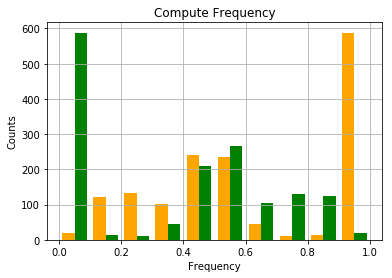

In [25]:
x = P150_df['AF']
reference = 1 - P150_df['AF']

plt.xlabel('Frequency')
plt.ylabel('Counts')
plt.title('Compute Frequency')
plt.grid(True)

plt.hist([x, reference], color=['orange', 'green']) 
plt.show()

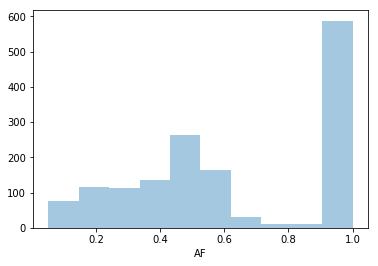

In [26]:
x = P150_df['AF']
espejo = 1 - P150_df['AF']

sns.distplot(x, kde=False, rug=False)
#sns.distplot(espejo, kde=False, rug=False)

In [65]:
P150_df['AF'].mean(axis = 0) 

0.387087770184361

In [27]:
def scatter_vcf(vcf_df):
    y = vcf_df['AF'][vcf_df['AF'] < 1]
    x = vcf_df['AF'][vcf_df['AF'] < 1].index.values
    
    mean = vcf_df['AF'].mean(axis = 0)
    
    col_mean = np.where(vcf_df['AF'][vcf_df['AF'] < 1] > mean,'c','r')
    
    plt.figure(figsize=(50,20))
    plt.margins(x=0.01, y=0.01, tight=True)

    plt.xlabel('Frequency')
    plt.ylabel('Counts')
    plt.title('Compute Frequency')
    plt.grid(True)
    

    plt.scatter(x, y, color=col_mean, alpha=0.5, s=200) # colormap='jet'
    plt.show()
    

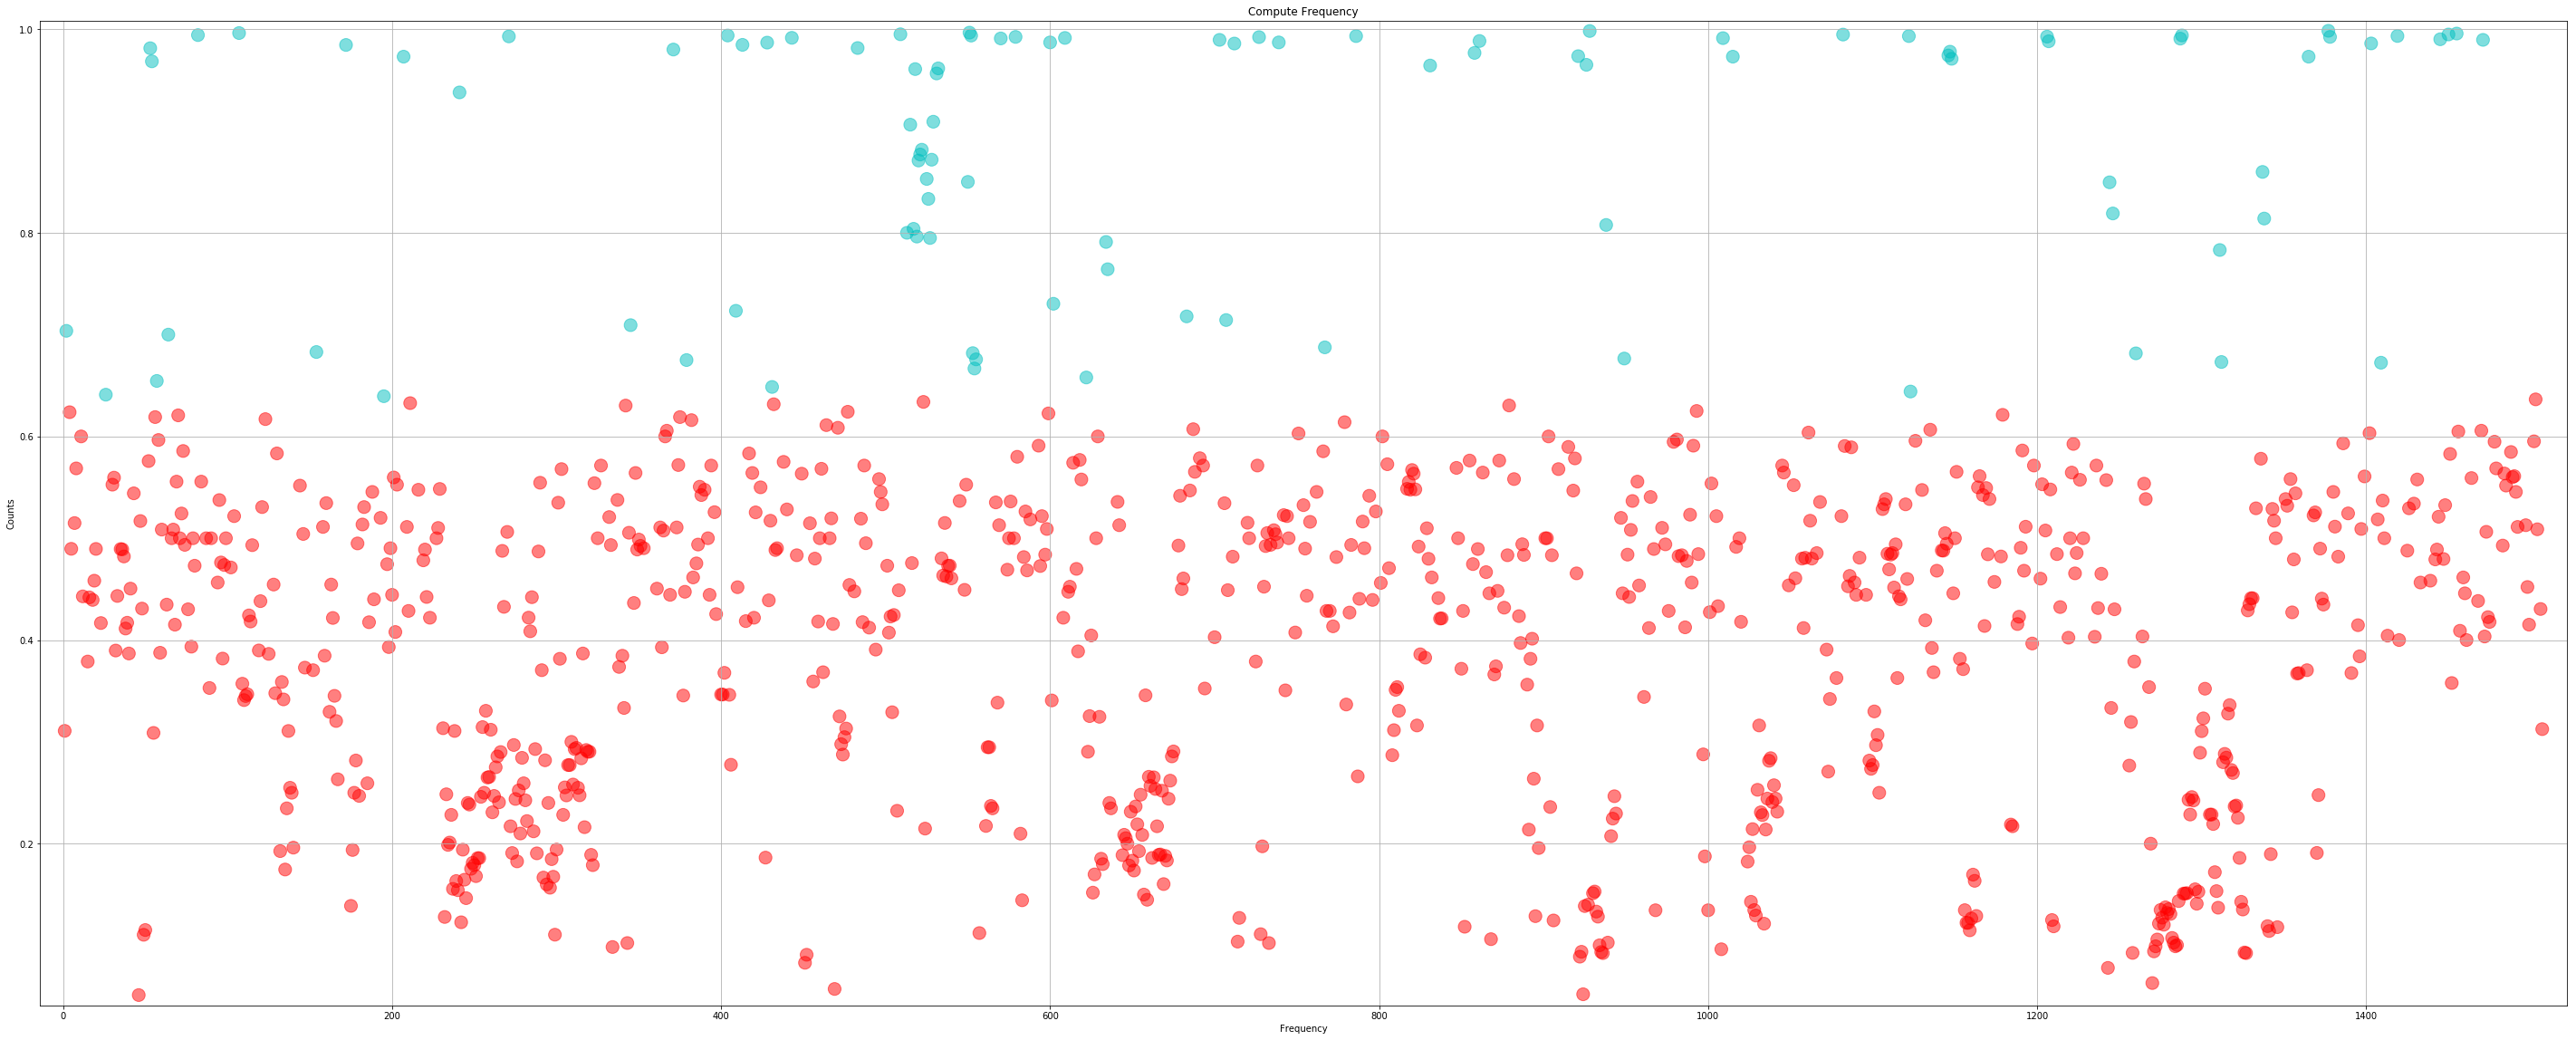

In [28]:
scatter_vcf(P150_df)

# FILTER REPEATS

In [29]:
list_positions = []
with open("data/repeats_annot.coords.tab") as f:
    for _ in range(1):
        next(f)
    for line in f:
        split_line = line.strip().split("\t")
        expression = "((row['POS'] >= %s) & (row['POS'] <= %s))" % (split_line[0], split_line[1])
        list_positions.append(expression)
print("(" + "|".join(list_positions) + ")")

(((row['POS'] >= 33582 ) & (row['POS'] <=  33794))|((row['POS'] >= 103710 ) & (row['POS'] <=  104663))|((row['POS'] >= 104805 ) & (row['POS'] <=  105215))|((row['POS'] >= 105324 ) & (row['POS'] <=  106715))|((row['POS'] >= 131382 ) & (row['POS'] <=  132872))|((row['POS'] >= 149533 ) & (row['POS'] <=  150996))|((row['POS'] >= 177543 ) & (row['POS'] <=  179309))|((row['POS'] >= 179319 ) & (row['POS'] <=  180896))|((row['POS'] >= 187433 ) & (row['POS'] <=  188839))|((row['POS'] >= 188931 ) & (row['POS'] <=  190439))|((row['POS'] >= 307877 ) & (row['POS'] <=  309547))|((row['POS'] >= 333437 ) & (row['POS'] <=  336310))|((row['POS'] >= 336560 ) & (row['POS'] <=  339073))|((row['POS'] >= 339364 ) & (row['POS'] <=  340974))|((row['POS'] >= 349624 ) & (row['POS'] <=  349932))|((row['POS'] >= 349935 ) & (row['POS'] <=  351476))|((row['POS'] >= 361334 ) & (row['POS'] <=  363109))|((row['POS'] >= 366150 ) & (row['POS'] <=  372764))|((row['POS'] >= 372820 ) & (row['POS'] <=  375711))|((row['POS'] 

In [30]:
def filter_repeats(row):
    if ((row['POS'] >= 33582 ) & (row['POS'] <=  33794))|((row['POS'] >= 103710 ) & (row['POS'] <=  104663))|((row['POS'] >= 104805 ) & (row['POS'] <=  105215))|((row['POS'] >= 105324 ) & (row['POS'] <=  106715))|((row['POS'] >= 131382 ) & (row['POS'] <=  132872))|((row['POS'] >= 149533 ) & (row['POS'] <=  150996))|((row['POS'] >= 177543 ) & (row['POS'] <=  179309))|((row['POS'] >= 179319 ) & (row['POS'] <=  180896))|((row['POS'] >= 187433 ) & (row['POS'] <=  188839))|((row['POS'] >= 188931 ) & (row['POS'] <=  190439))|((row['POS'] >= 307877 ) & (row['POS'] <=  309547))|((row['POS'] >= 333437 ) & (row['POS'] <=  336310))|((row['POS'] >= 336560 ) & (row['POS'] <=  339073))|((row['POS'] >= 339364 ) & (row['POS'] <=  340974))|((row['POS'] >= 349624 ) & (row['POS'] <=  349932))|((row['POS'] >= 349935 ) & (row['POS'] <=  351476))|((row['POS'] >= 361334 ) & (row['POS'] <=  363109))|((row['POS'] >= 366150 ) & (row['POS'] <=  372764))|((row['POS'] >= 372820 ) & (row['POS'] <=  375711))|((row['POS'] >= 399535 ) & (row['POS'] <=  400050))|((row['POS'] >= 400192 ) & (row['POS'] <=  401703))|((row['POS'] >= 424269 ) & (row['POS'] <=  424694))|((row['POS'] >= 424777 ) & (row['POS'] <=  434679))|((row['POS'] >= 466672 ) & (row['POS'] <=  467406))|((row['POS'] >= 467459 ) & (row['POS'] <=  468001))|((row['POS'] >= 472781 ) & (row['POS'] <=  474106))|((row['POS'] >= 475816 ) & (row['POS'] <=  476184))|((row['POS'] >= 530751 ) & (row['POS'] <=  532214))|((row['POS'] >= 543174 ) & (row['POS'] <=  544730))|((row['POS'] >= 606551 ) & (row['POS'] <=  608062))|((row['POS'] >= 622793 ) & (row['POS'] <=  624577))|((row['POS'] >= 671996 ) & (row['POS'] <=  675916))|((row['POS'] >= 832534 ) & (row['POS'] <=  832848))|((row['POS'] >= 832981 ) & (row['POS'] <=  833508))|((row['POS'] >= 835701 ) & (row['POS'] <=  838052))|((row['POS'] >= 838451 ) & (row['POS'] <=  840856))|((row['POS'] >= 846159 ) & (row['POS'] <=  847913))|((row['POS'] >= 848103 ) & (row['POS'] <=  850040))|((row['POS'] >= 850342 ) & (row['POS'] <=  850527))|((row['POS'] >= 889072 ) & (row['POS'] <=  889398))|((row['POS'] >= 889395 ) & (row['POS'] <=  890333))|((row['POS'] >= 890388 ) & (row['POS'] <=  891482))|((row['POS'] >= 924951 ) & (row['POS'] <=  925364))|((row['POS'] >= 925361 ) & (row['POS'] <=  927610))|((row['POS'] >= 927837 ) & (row['POS'] <=  930485))|((row['POS'] >= 947312 ) & (row['POS'] <=  947644))|((row['POS'] >= 968424 ) & (row['POS'] <=  970244))|((row['POS'] >= 976872 ) & (row['POS'] <=  978203))|((row['POS'] >= 1020058 ) & (row['POS'] <=  1021329))|((row['POS'] >= 1021344 ) & (row['POS'] <=  1021643))|((row['POS'] >= 1025497 ) & (row['POS'] <=  1026816))|((row['POS'] >= 1027104 ) & (row['POS'] <=  1027685))|((row['POS'] >= 1027685 ) & (row['POS'] <=  1029337))|((row['POS'] >= 1090373 ) & (row['POS'] <=  1093144))|((row['POS'] >= 1093361 ) & (row['POS'] <=  1094356))|((row['POS'] >= 1095078 ) & (row['POS'] <=  1096451))|((row['POS'] >= 1158918 ) & (row['POS'] <=  1159307))|((row['POS'] >= 1159375 ) & (row['POS'] <=  1160061))|((row['POS'] >= 1161297 ) & (row['POS'] <=  1162472))|((row['POS'] >= 1162549 ) & (row['POS'] <=  1163376))|((row['POS'] >= 1164572 ) & (row['POS'] <=  1165435))|((row['POS'] >= 1165092 ) & (row['POS'] <=  1165499))|((row['POS'] >= 1169423 ) & (row['POS'] <=  1170670))|((row['POS'] >= 1176928 ) & (row['POS'] <=  1177242))|((row['POS'] >= 1188421 ) & (row['POS'] <=  1190424))|((row['POS'] >= 1190757 ) & (row['POS'] <=  1192148))|((row['POS'] >= 1211560 ) & (row['POS'] <=  1213863))|((row['POS'] >= 1214513 ) & (row['POS'] <=  1214947))|((row['POS'] >= 1214769 ) & (row['POS'] <=  1215131))|((row['POS'] >= 1216469 ) & (row['POS'] <=  1219030))|((row['POS'] >= 1251617 ) & (row['POS'] <=  1252972))|((row['POS'] >= 1262272 ) & (row['POS'] <=  1264128))|((row['POS'] >= 1276300 ) & (row['POS'] <=  1277748))|((row['POS'] >= 1277893 ) & (row['POS'] <=  1278300))|((row['POS'] >= 1298764 ) & (row['POS'] <=  1299804))|((row['POS'] >= 1299822 ) & (row['POS'] <=  1300124))|((row['POS'] >= 1301755 ) & (row['POS'] <=  1302681))|((row['POS'] >= 1339003 ) & (row['POS'] <=  1339302))|((row['POS'] >= 1339349 ) & (row['POS'] <=  1340524))|((row['POS'] >= 1341358 ) & (row['POS'] <=  1342605))|((row['POS'] >= 1357293 ) & (row['POS'] <=  1357625))|((row['POS'] >= 1384989 ) & (row['POS'] <=  1386677))|((row['POS'] >= 1468171 ) & (row['POS'] <=  1469505))|((row['POS'] >= 1488154 ) & (row['POS'] <=  1489965))|((row['POS'] >= 1532443 ) & (row['POS'] <=  1533633))|((row['POS'] >= 1541994 ) & (row['POS'] <=  1542878))|((row['POS'] >= 1542929 ) & (row['POS'] <=  1543255))|((row['POS'] >= 1561464 ) & (row['POS'] <=  1561772))|((row['POS'] >= 1561769 ) & (row['POS'] <=  1563388))|((row['POS'] >= 1572127 ) & (row['POS'] <=  1573857))|((row['POS'] >= 1606386 ) & (row['POS'] <=  1607972))|((row['POS'] >= 1618209 ) & (row['POS'] <=  1619684))|((row['POS'] >= 1630638 ) & (row['POS'] <=  1634627))|((row['POS'] >= 1636004 ) & (row['POS'] <=  1638229))|((row['POS'] >= 1655609 ) & (row['POS'] <=  1656721))|((row['POS'] >= 1751297 ) & (row['POS'] <=  1753333))|((row['POS'] >= 1779194 ) & (row['POS'] <=  1779298))|((row['POS'] >= 1779314 ) & (row['POS'] <=  1779724))|((row['POS'] >= 1779930 ) & (row['POS'] <=  1780241))|((row['POS'] >= 1780199 ) & (row['POS'] <=  1780699))|((row['POS'] >= 1780643 ) & (row['POS'] <=  1782064))|((row['POS'] >= 1782072 ) & (row['POS'] <=  1782584))|((row['POS'] >= 1782758 ) & (row['POS'] <=  1783228))|((row['POS'] >= 1783309 ) & (row['POS'] <=  1783623))|((row['POS'] >= 1783620 ) & (row['POS'] <=  1783892))|((row['POS'] >= 1783906 ) & (row['POS'] <=  1784301))|((row['POS'] >= 1784497 ) & (row['POS'] <=  1785912))|((row['POS'] >= 1785912 ) & (row['POS'] <=  1786310))|((row['POS'] >= 1786307 ) & (row['POS'] <=  1786528))|((row['POS'] >= 1786584 ) & (row['POS'] <=  1787099))|((row['POS'] >= 1787096 ) & (row['POS'] <=  1788505))|((row['POS'] >= 1788162 ) & (row['POS'] <=  1789163))|((row['POS'] >= 1789168 ) & (row['POS'] <=  1789836))|((row['POS'] >= 1855764 ) & (row['POS'] <=  1856696))|((row['POS'] >= 1862347 ) & (row['POS'] <=  1865382))|((row['POS'] >= 1931497 ) & (row['POS'] <=  1932654))|((row['POS'] >= 1932694 ) & (row['POS'] <=  1933878))|((row['POS'] >= 1981614 ) & (row['POS'] <=  1984775))|((row['POS'] >= 1987745 ) & (row['POS'] <=  1988629))|((row['POS'] >= 1988680 ) & (row['POS'] <=  1989006))|((row['POS'] >= 1989833 ) & (row['POS'] <=  1992577))|((row['POS'] >= 1996152 ) & (row['POS'] <=  1996478))|((row['POS'] >= 1996529 ) & (row['POS'] <=  1997413))|((row['POS'] >= 1999142 ) & (row['POS'] <=  1999357)):
        return True
    elif ((row['POS'] >= 2000614 ) & (row['POS'] <=  2002470))|((row['POS'] >= 2025301 ) & (row['POS'] <=  2026398))|((row['POS'] >= 2026477 ) & (row['POS'] <=  2026776))|((row['POS'] >= 2026790 ) & (row['POS'] <=  2027971))|((row['POS'] >= 2028425 ) & (row['POS'] <=  2029477))|((row['POS'] >= 2029904 ) & (row['POS'] <=  2030203))|((row['POS'] >= 2039453 ) & (row['POS'] <=  2041420))|((row['POS'] >= 2042001 ) & (row['POS'] <=  2043272))|((row['POS'] >= 2043384 ) & (row['POS'] <=  2044775))|((row['POS'] >= 2044923 ) & (row['POS'] <=  2046842))|((row['POS'] >= 2048072 ) & (row['POS'] <=  2048371))|((row['POS'] >= 2048398 ) & (row['POS'] <=  2049597))|((row['POS'] >= 2049921 ) & (row['POS'] <=  2051150))|((row['POS'] >= 2051282 ) & (row['POS'] <=  2052688))|((row['POS'] >= 2061178 ) & (row['POS'] <=  2062674))|((row['POS'] >= 2087971 ) & (row['POS'] <=  2089518))|((row['POS'] >= 2162932 ) & (row['POS'] <=  2167311))|((row['POS'] >= 2167649 ) & (row['POS'] <=  2170612))|((row['POS'] >= 2195989 ) & (row['POS'] <=  2197353))|((row['POS'] >= 2226244 ) & (row['POS'] <=  2227920))|((row['POS'] >= 2260665 ) & (row['POS'] <=  2261144))|((row['POS'] >= 2261098 ) & (row['POS'] <=  2261688))|((row['POS'] >= 2358389 ) & (row['POS'] <=  2360041))|((row['POS'] >= 2365465 ) & (row['POS'] <=  2365791))|((row['POS'] >= 2365788 ) & (row['POS'] <=  2366726))|((row['POS'] >= 2367359 ) & (row['POS'] <=  2367655))|((row['POS'] >= 2367711 ) & (row['POS'] <=  2368442))|((row['POS'] >= 2381071 ) & (row['POS'] <=  2382492))|((row['POS'] >= 2387202 ) & (row['POS'] <=  2387972))|((row['POS'] >= 2423240 ) & (row['POS'] <=  2424838))|((row['POS'] >= 2430159 ) & (row['POS'] <=  2431199))|((row['POS'] >= 2431094 ) & (row['POS'] <=  2431420))|((row['POS'] >= 2439282 ) & (row['POS'] <=  2439947))|((row['POS'] >= 2550065 ) & (row['POS'] <=  2550391))|((row['POS'] >= 2550388 ) & (row['POS'] <=  2551326))|((row['POS'] >= 2600731 ) & (row['POS'] <=  2601879))|((row['POS'] >= 2617667 ) & (row['POS'] <=  2618908))|((row['POS'] >= 2632923 ) & (row['POS'] <=  2634098))|((row['POS'] >= 2634528 ) & (row['POS'] <=  2635592))|((row['POS'] >= 2635628 ) & (row['POS'] <=  2635954))|((row['POS'] >= 2635951 ) & (row['POS'] <=  2636889))|((row['POS'] >= 2637688 ) & (row['POS'] <=  2639535))|((row['POS'] >= 2651753 ) & (row['POS'] <=  2651938))|((row['POS'] >= 2692799 ) & (row['POS'] <=  2693884))|((row['POS'] >= 2706017 ) & (row['POS'] <=  2706736))|((row['POS'] >= 2720776 ) & (row['POS'] <=  2721777))|((row['POS'] >= 2727336 ) & (row['POS'] <=  2727920))|((row['POS'] >= 2727967 ) & (row['POS'] <=  2728266))|((row['POS'] >= 2784657 ) & (row['POS'] <=  2785697))|((row['POS'] >= 2785592 ) & (row['POS'] <=  2785918))|((row['POS'] >= 2795301 ) & (row['POS'] <=  2797385))|((row['POS'] >= 2801254 ) & (row['POS'] <=  2806236))|((row['POS'] >= 2828556 ) & (row['POS'] <=  2829803))|((row['POS'] >= 2835785 ) & (row['POS'] <=  2837263))|((row['POS'] >= 2921551 ) & (row['POS'] <=  2923182))|((row['POS'] >= 2935046 ) & (row['POS'] <=  2936788))|((row['POS'] >= 2943600 ) & (row['POS'] <=  2944985))|((row['POS'] >= 2960105 ) & (row['POS'] <=  2962441))|((row['POS'] >= 2970551 ) & (row['POS'] <=  2971549))|((row['POS'] >= 2972160 ) & (row['POS'] <=  2972486))|((row['POS'] >= 2972435 ) & (row['POS'] <=  2973421))|((row['POS'] >= 2973795 ) & (row['POS'] <=  2975234))|((row['POS'] >= 2975242 ) & (row['POS'] <=  2975775))|((row['POS'] >= 2975928 ) & (row['POS'] <=  2976554))|((row['POS'] >= 2976586 ) & (row['POS'] <=  2976909))|((row['POS'] >= 2976989 ) & (row['POS'] <=  2977234))|((row['POS'] >= 2977231 ) & (row['POS'] <=  2978658))|((row['POS'] >= 2978660 ) & (row['POS'] <=  2979052))|((row['POS'] >= 2979049 ) & (row['POS'] <=  2979309))|((row['POS'] >= 2979326 ) & (row['POS'] <=  2979688))|((row['POS'] >= 2979691 ) & (row['POS'] <=  2980818))|((row['POS'] >= 2983071 ) & (row['POS'] <=  2983874))|((row['POS'] >= 3053914 ) & (row['POS'] <=  3055491))|((row['POS'] >= 3076894 ) & (row['POS'] <=  3078078))|((row['POS'] >= 3078158 ) & (row['POS'] <=  3078985))|((row['POS'] >= 3079309 ) & (row['POS'] <=  3080457))|((row['POS'] >= 3100202 ) & (row['POS'] <=  3101581))|((row['POS'] >= 3115741 ) & (row['POS'] <=  3116142))|((row['POS'] >= 3116818 ) & (row['POS'] <=  3118227))|((row['POS'] >= 3120566 ) & (row['POS'] <=  3121504))|((row['POS'] >= 3121501 ) & (row['POS'] <=  3121827))|((row['POS'] >= 3162268 ) & (row['POS'] <=  3164115))|((row['POS'] >= 3194166 ) & (row['POS'] <=  3195548))|((row['POS'] >= 3200794 ) & (row['POS'] <=  3202020))|((row['POS'] >= 3288464 ) & (row['POS'] <=  3289705))|((row['POS'] >= 3289705 ) & (row['POS'] <=  3290235))|((row['POS'] >= 3289790 ) & (row['POS'] <=  3290506))|((row['POS'] >= 3313283 ) & (row['POS'] <=  3313672))|((row['POS'] >= 3333785 ) & (row['POS'] <=  3335164))|((row['POS'] >= 3376939 ) & (row['POS'] <=  3378243))|((row['POS'] >= 3378329 ) & (row['POS'] <=  3378415))|((row['POS'] >= 3379376 ) & (row['POS'] <=  3380452))|((row['POS'] >= 3380440 ) & (row['POS'] <=  3380682))|((row['POS'] >= 3380679 ) & (row['POS'] <=  3380993))|((row['POS'] >= 3381375 ) & (row['POS'] <=  3382622))|((row['POS'] >= 3465778 ) & (row['POS'] <=  3467091))|((row['POS'] >= 3481451 ) & (row['POS'] <=  3482698))|((row['POS'] >= 3490476 ) & (row['POS'] <=  3491651))|((row['POS'] >= 3501334 ) & (row['POS'] <=  3501732))|((row['POS'] >= 3501794 ) & (row['POS'] <=  3502936))|((row['POS'] >= 3510088 ) & (row['POS'] <=  3511317))|((row['POS'] >= 3527391 ) & (row['POS'] <=  3529163))|((row['POS'] >= 3551281 ) & (row['POS'] <=  3551607))|((row['POS'] >= 3551604 ) & (row['POS'] <=  3552542))|((row['POS'] >= 3552764 ) & (row['POS'] <=  3553090))|((row['POS'] >= 3553087 ) & (row['POS'] <=  3554025))|((row['POS'] >= 3557311 ) & (row['POS'] <=  3558345))|((row['POS'] >= 3710433 ) & (row['POS'] <=  3710759))|((row['POS'] >= 3710756 ) & (row['POS'] <=  3711694))|((row['POS'] >= 3711749 ) & (row['POS'] <=  3713461))|((row['POS'] >= 3729364 ) & (row['POS'] <=  3736935))|((row['POS'] >= 3736984 ) & (row['POS'] <=  3738438))|((row['POS'] >= 3738158 ) & (row['POS'] <=  3742774))|((row['POS'] >= 3743711 ) & (row['POS'] <=  3753184))|((row['POS'] >= 3753765 ) & (row['POS'] <=  3754256))|((row['POS'] >= 3754293 ) & (row['POS'] <=  3755033))|((row['POS'] >= 3755952 ) & (row['POS'] <=  3767102))|((row['POS'] >= 3778568 ) & (row['POS'] <=  3780334))|((row['POS'] >= 3795100 ) & (row['POS'] <=  3795984))|((row['POS'] >= 3796035 ) & (row['POS'] <=  3796361))|((row['POS'] >= 3800092 ) & (row['POS'] <=  3800796))|((row['POS'] >= 3800786 ) & (row['POS'] <=  3801463))|((row['POS'] >= 3801653 ) & (row['POS'] <=  3803848))|((row['POS'] >= 3842239 ) & (row['POS'] <=  3842769))|((row['POS'] >= 3843036 ) & (row['POS'] <=  3843734))|((row['POS'] >= 3843885 ) & (row['POS'] <=  3844640))|((row['POS'] >= 3844738 ) & (row['POS'] <=  3845970))|((row['POS'] >= 3847165 ) & (row['POS'] <=  3847701))|((row['POS'] >= 3883525 ) & (row['POS'] <=  3884193))|((row['POS'] >= 3883964 ) & (row['POS'] <=  3884917))|((row['POS'] >= 3890830 ) & (row['POS'] <=  3891156))|((row['POS'] >= 3891051 ) & (row['POS'] <=  3892091))|((row['POS'] >= 3894093 ) & (row['POS'] <=  3894389))|((row['POS'] >= 3894426 ) & (row['POS'] <=  3895607))|((row['POS'] >= 3926569 ) & (row['POS'] <=  3930714))|((row['POS'] >= 3931005 ) & (row['POS'] <=  3936710))|((row['POS'] >= 3939617 ) & (row['POS'] <=  3941761))|((row['POS'] >= 3941724 ) & (row['POS'] <=  3944963))|((row['POS'] >= 3945794 ) & (row['POS'] <=  3950263))|((row['POS'] >= 3969343 ) & (row['POS'] <=  3970563))|((row['POS'] >= 3970705 ) & (row['POS'] <=  3972453))|((row['POS'] >= 3978059 ) & (row['POS'] <=  3979498))|((row['POS'] >= 3997980 ) & (row['POS'] <=  3999638))|((row['POS'] >= 4031404 ) & (row['POS'] <=  4033158))|((row['POS'] >= 4036731 ) & (row['POS'] <=  4038050))|((row['POS'] >= 4060648 ) & (row['POS'] <=  4061889))|((row['POS'] >= 4061899 ) & (row['POS'] <=  4062198))|((row['POS'] >= 4075752 ) & (row['POS'] <=  4076099))|((row['POS'] >= 4076484 ) & (row['POS'] <=  4076984))|((row['POS'] >= 4076984 ) & (row['POS'] <=  4077730))|((row['POS'] >= 4091233 ) & (row['POS'] <=  4091517))|((row['POS'] >= 4093632 ) & (row['POS'] <=  4093946))|((row['POS'] >= 4093940 ) & (row['POS'] <=  4094527))|((row['POS'] >= 4189285 ) & (row['POS'] <=  4190232))|((row['POS'] >= 4190284 ) & (row['POS'] <=  4190517))|((row['POS'] >= 4196171 ) & (row['POS'] <=  4196506))|((row['POS'] >= 4198874 ) & (row['POS'] <=  4199089))|((row['POS'] >= 4252993 ) & (row['POS'] <=  4254327))|((row['POS'] >= 4276571 ) & (row['POS'] <=  4278085))|((row['POS'] >= 4301563 ) & (row['POS'] <=  4302789))|((row['POS'] >= 4318775 ) & (row['POS'] <=  4319266))|((row['POS'] >= 4350745 ) & (row['POS'] <=  4351044))|((row['POS'] >= 4351075 ) & (row['POS'] <=  4352181))|((row['POS'] >= 4374484 ) & (row['POS'] <=  4375683))|((row['POS'] >= 4375762 ) & (row['POS'] <=  4375995)):
        return True
    else:
        return False

In [31]:
P150_df.head()

Chrom   POS Ref Cons  Reads1  Reads2 VarFreq  Strands1  Strands2  Qual1  \
0  MTB_anc  2532   C    T       0     125    100%         0         2      0   
1  MTB_anc  6140   G    T     102      46  31.08%         2         2     43   
2  MTB_anc  7585   C    G      16      38  70.37%         2         2     43   
3  MTB_anc  9143   C    T       0      84    100%         0         2      0   
4  MTB_anc  9304   A    G      38      63  62.38%         2         2     44   

   Qual2  Pvalue  MapQual1  MapQual2  Reads1Plus  Reads1Minus  Reads2Plus  \
0     45    0.98         0         1           0            0          82   
1     46    0.98         1         1          63           39          29   
2     44    0.98         1         1          11            5          24   
3     44    0.98         0         1           0            0          49   
4     45    0.98         1         1          25           13          40   

   Reads2Minus VarAllele      AF  
0           43         T  1.0000  
1           17         T  0.3108  
2           14         G  0.7037  
3           35         T  1.0000  
4           23         G  0.6238

## Apply repeat info

In [32]:
P150_df['Is_repeat'] = P150_df.apply(filter_repeats, axis=1)
P180_df['Is_repeat'] = P180_df.apply(filter_repeats, axis=1)
P190_df['Is_repeat'] = P190_df.apply(filter_repeats, axis=1)

In [33]:
P150_df_nr = P150_df[P150_df['Is_repeat'] == False].reset_index(drop=True)
P180_df_nr = P180_df[P180_df['Is_repeat'] == False].reset_index(drop=True)
P190_df_nr = P190_df[P190_df['Is_repeat'] == False].reset_index(drop=True)

In [34]:
def scatter_vcf_pos(vcf_df):
    y = vcf_df['AF'][vcf_df['AF'] < 1]
    x = vcf_df['POS'][vcf_df['AF'] < 1]
    plt.figure(figsize=(100,25))
    plt.margins(x=0.01, y=0.01, tight=True)
    
    mean = vcf_df['AF'][vcf_df['AF'] < 1].mean(axis = 0)
    
    col_mean = np.where(vcf_df['AF'][vcf_df['AF'] < 1] > mean,'c','salmon')

    plt.xlabel('Frequency')
    plt.ylabel('Counts')
    plt.title('Compute Frequency')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='1', color='k')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='1', color='k')
    
    # Turn on/off the display of all ticks.
    plt.tick_params(which='minor', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='on') # turn on bottom ticks
    plt.grid(True)

    plt.scatter(x, y, color=col_mean, alpha=0.5, s=300)
    plt.show()

/home/laura/env36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


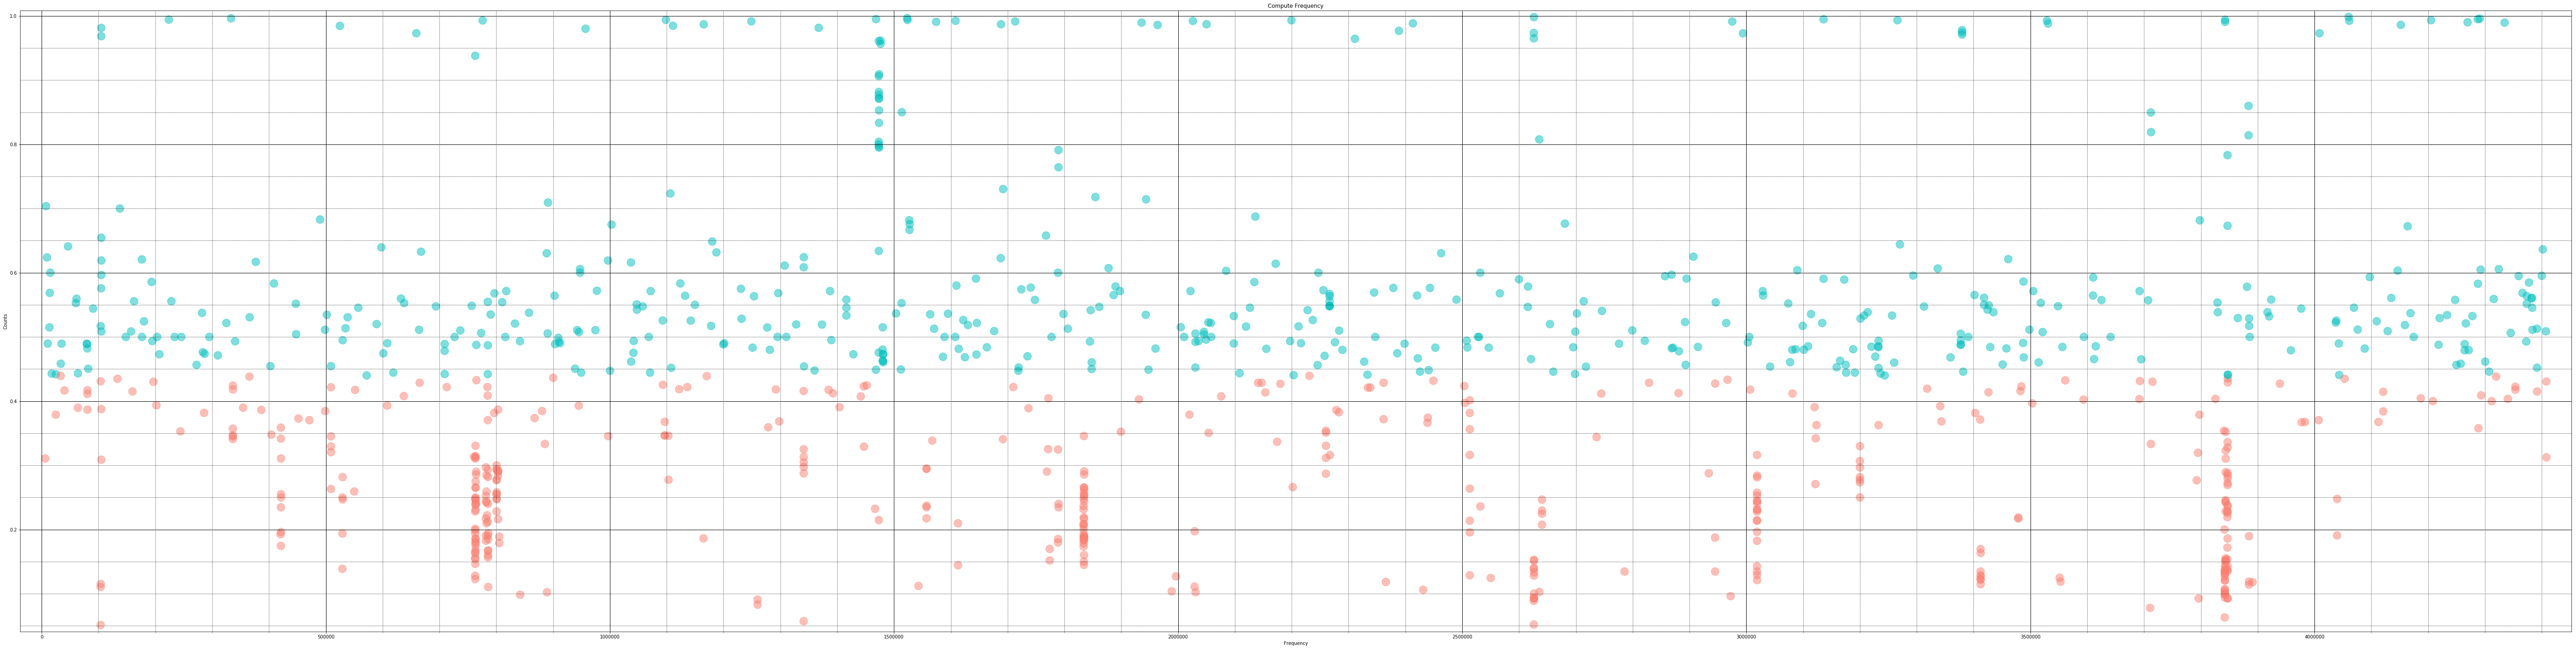

In [35]:
scatter_vcf_pos(P150_df)

In [36]:
P150_df.shape

(1510, 21)

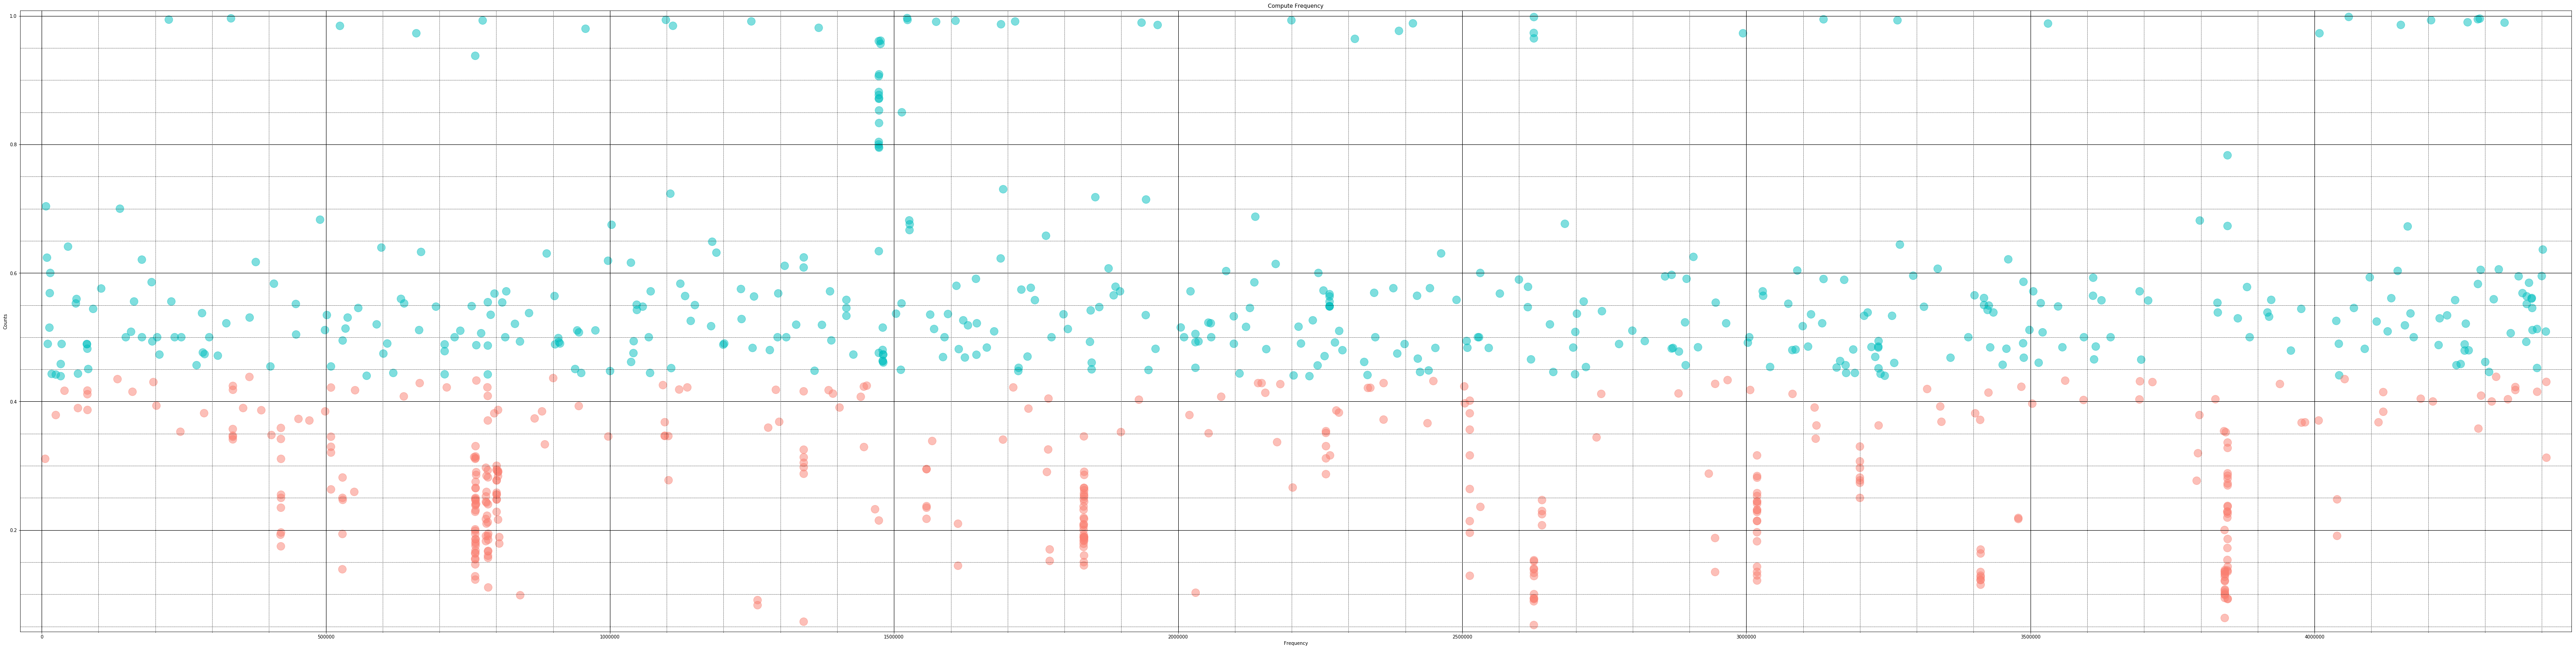

In [38]:
scatter_vcf_pos(P150_df_nr)

In [39]:
P150_df_nr.shape

(1360, 21)

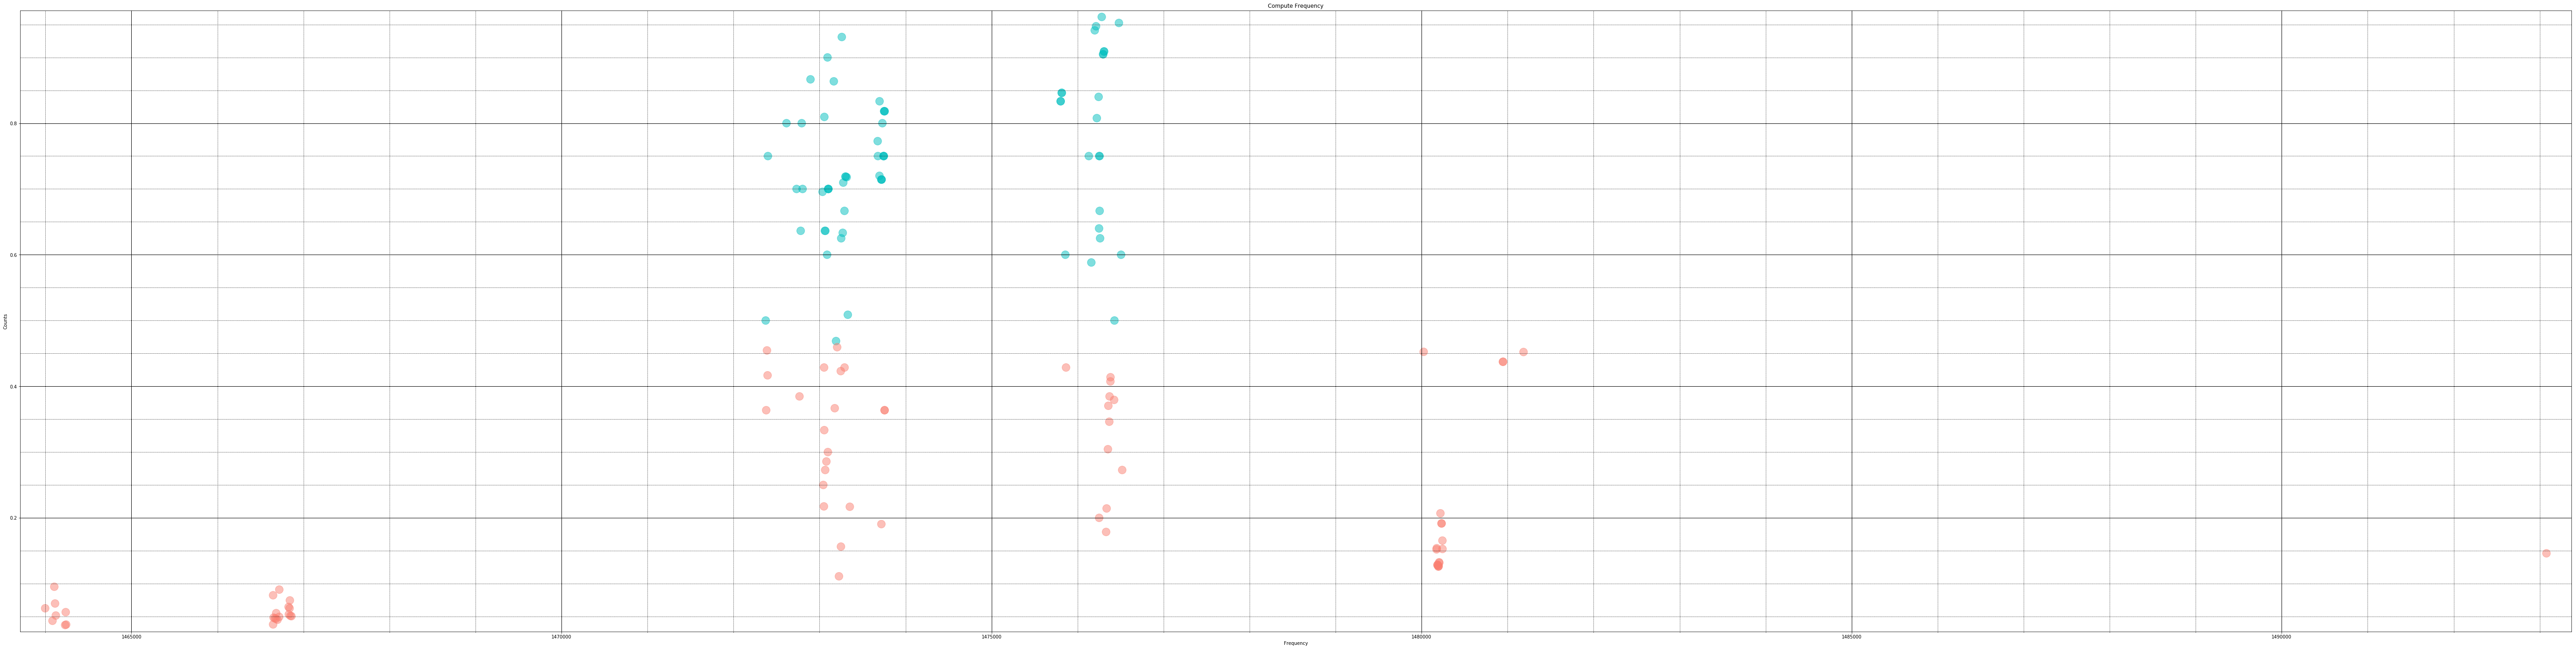

In [88]:
scatter_vcf_pos(P150_df_nr[(P150_df_nr['POS'] > 1460000) & (P150_df_nr['POS'] < 1500000)])

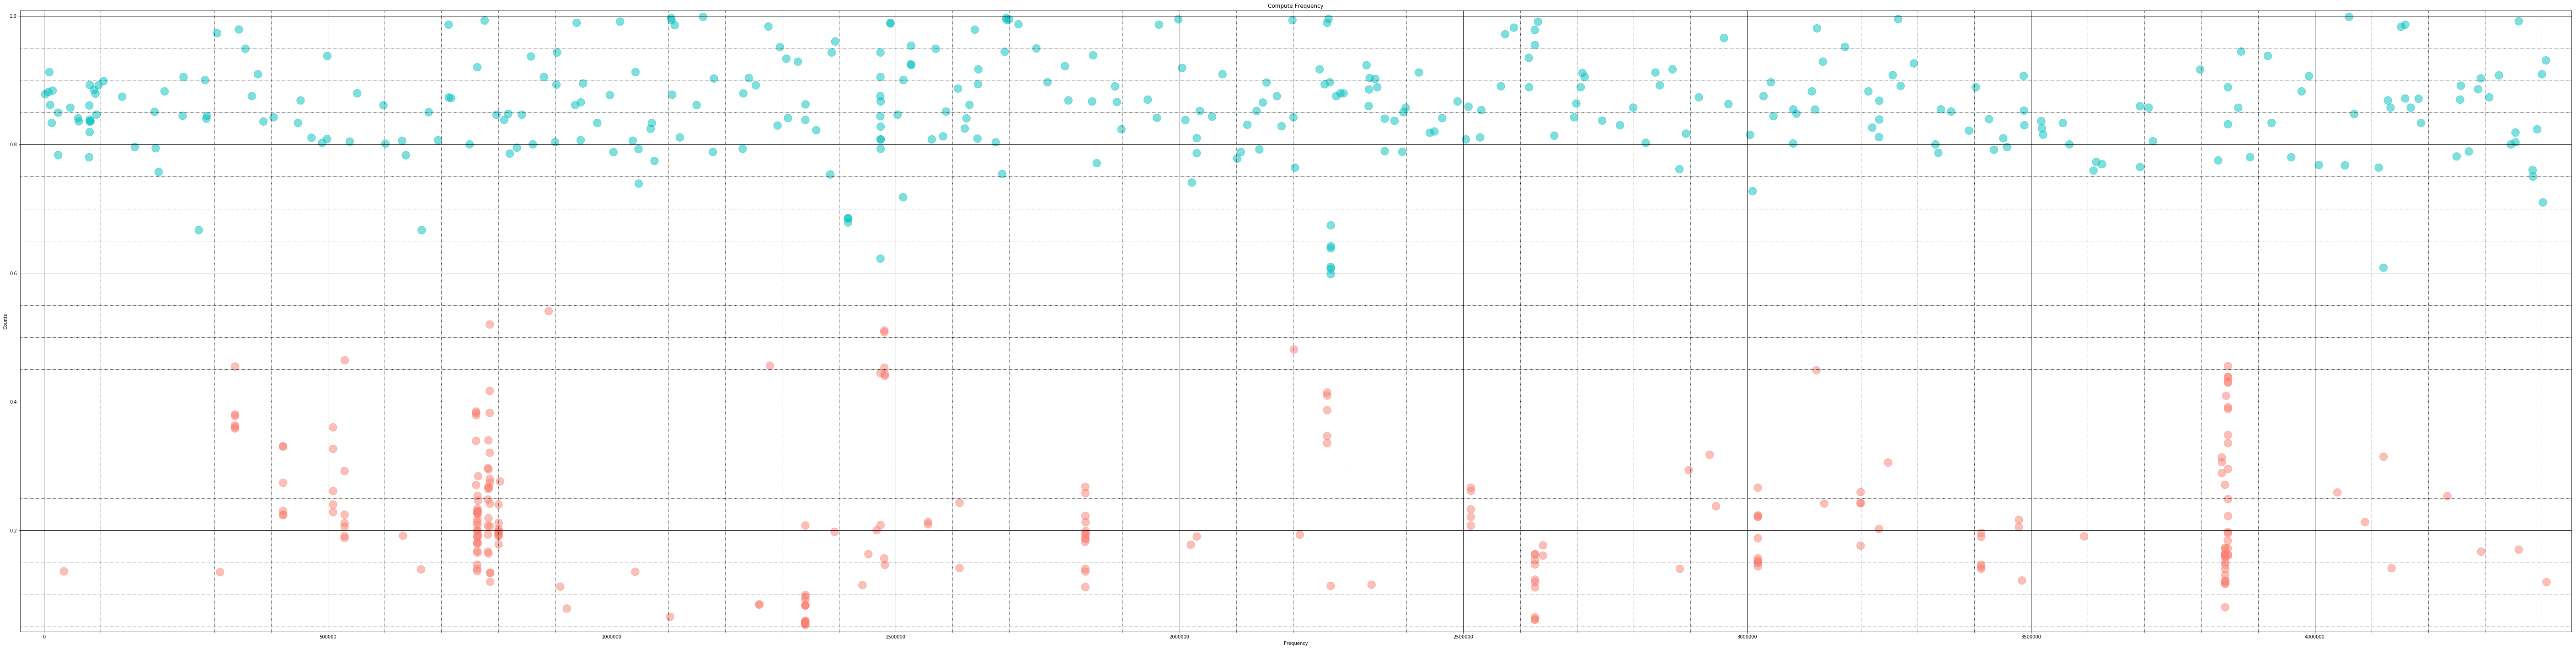

In [40]:
scatter_vcf_pos(P180_df_nr)

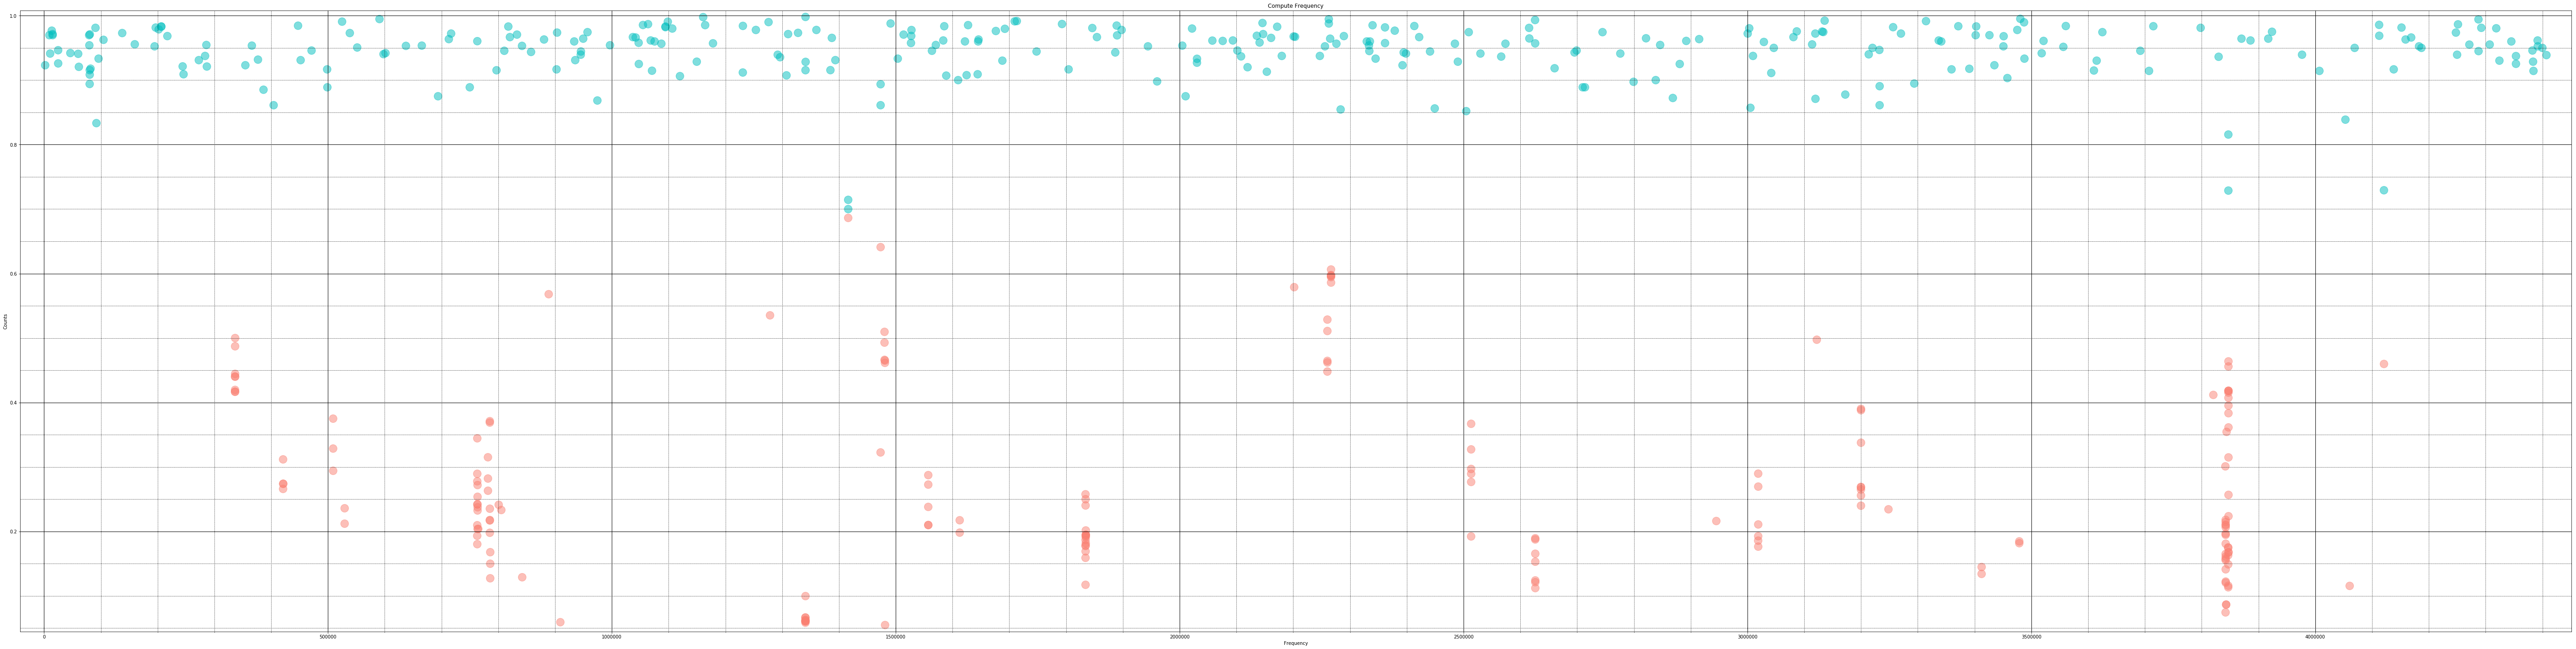

In [41]:
scatter_vcf_pos(P190_df_nr)

In [42]:
def create_bin(bin, max):
    for i in range(1, max, bin):
        print(i,i+bin-1)

In [43]:
print(len(P180_df_nr.index.values))

1076


In [45]:
print(P180_df_nr.loc[100,'POS'])

422745


In [46]:
def add_snp_distance(vcf_df):
    for index in vcf_df.index.values:
        if index > 0:
            vcf_df.loc[index,'snp_left_distance'] = vcf_df.loc[index,'POS'] - vcf_df.loc[index - 1,'POS']
        if index < (len(vcf_df.index.values) - 1):
            vcf_df.loc[index,'snp_right_distance'] = vcf_df.loc[index + 1,'POS'] - vcf_df.loc[index,'POS']
            
    return vcf_df

In [47]:
#P190_df_nr[P190_df_nr.isnull().any(axis=1)]

In [48]:
P190_df_nr_ds = add_snp_distance(P190_df_nr)
P180_df_nr_ds = add_snp_distance(P180_df_nr)
P150_df_nr_ds = add_snp_distance(P150_df_nr)

In [49]:
P180_df_nr_ds.tail()

Chrom      POS Ref Cons  Reads1  Reads2 VarFreq  Strands1  Strands2  \
1071  MTB_anc  4407110   G    C       5      67  93.06%         2         2   
1072  MTB_anc  4407588   C    T       0     134    100%         0         2   
1073  MTB_anc  4407970   G    A     177      24  11.94%         2         2   
1074  MTB_anc  4408920   G    A       0      85    100%         0         2   
1075  MTB_anc  4408923   T    C       0      83    100%         0         2   

      Qual1  ...  MapQual2  Reads1Plus  Reads1Minus  Reads2Plus  Reads2Minus  \
1071     37  ...         1           2            3          30           37   
1072      0  ...         1           0            0          95           39   
1073     49  ...         1         114           63          16            8   
1074      0  ...         1           0            0          42           43   
1075      0  ...         1           0            0          40           43   

      VarAllele      AF  Is_repeat snp_right_distance  snp_left_distance  
1071          C  0.9306      False              478.0             5357.0  
1072          T  1.0000      False              382.0              478.0  
1073          A  0.1194      False              950.0              382.0  
1074          A  1.0000      False                3.0              950.0  
1075          C  1.0000      False                NaN                3.0  

[5 rows x 23 columns]

In [50]:
P180_df_nr_ds['snp_left_distance'].describe()

count     1075.000000
mean      4099.484651
std       5288.548580
min          0.000000
25%        247.500000
50%       2087.000000
75%       6096.500000
max      39343.000000
Name: snp_left_distance, dtype: float64

In [51]:
def filter_by_distance(vcf_dist_df, distance):
    vcf_df_filtered_distance = vcf_dist_df[((vcf_dist_df['snp_right_distance'] > distance) | (vcf_dist_df['snp_left_distance'] > distance))]
    return vcf_df_filtered_distance

In [52]:
PAIR190_dsf = filter_by_distance(P190_df_nr_ds, 1500)
PAIR180_dsf = filter_by_distance(P180_df_nr_ds, 1500)
PAIR150_dsf = filter_by_distance(P150_df_nr_ds, 1500)

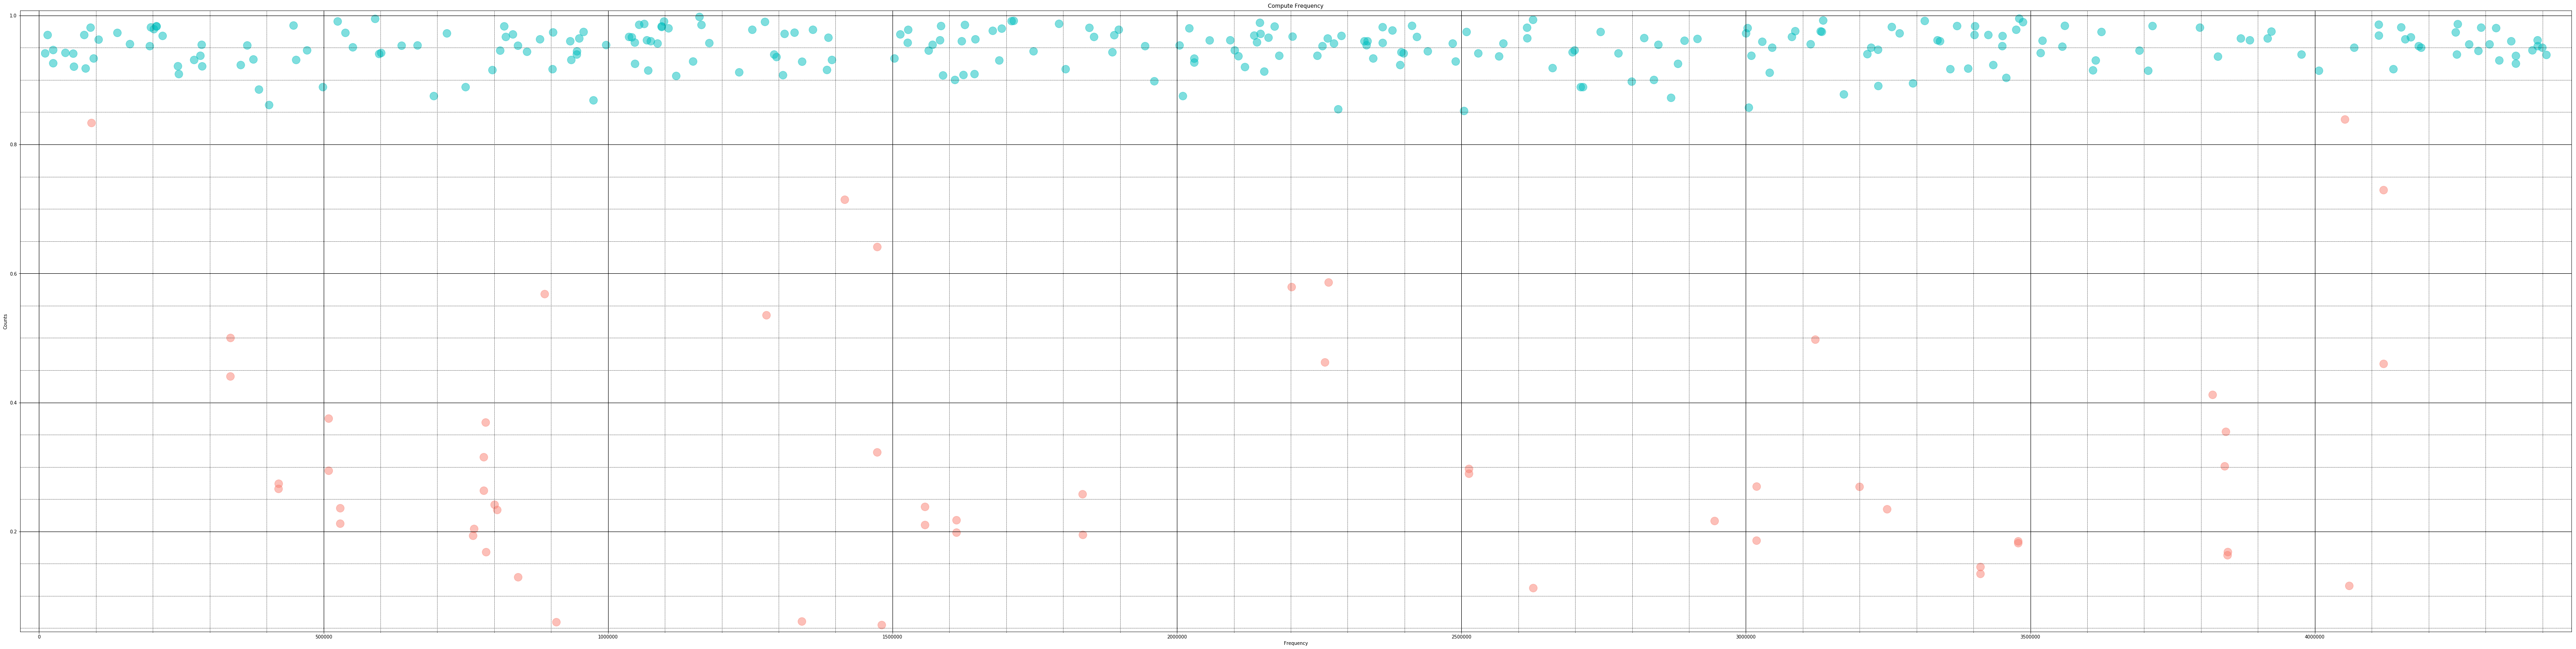

In [53]:
scatter_vcf_pos(PAIR190_dsf)

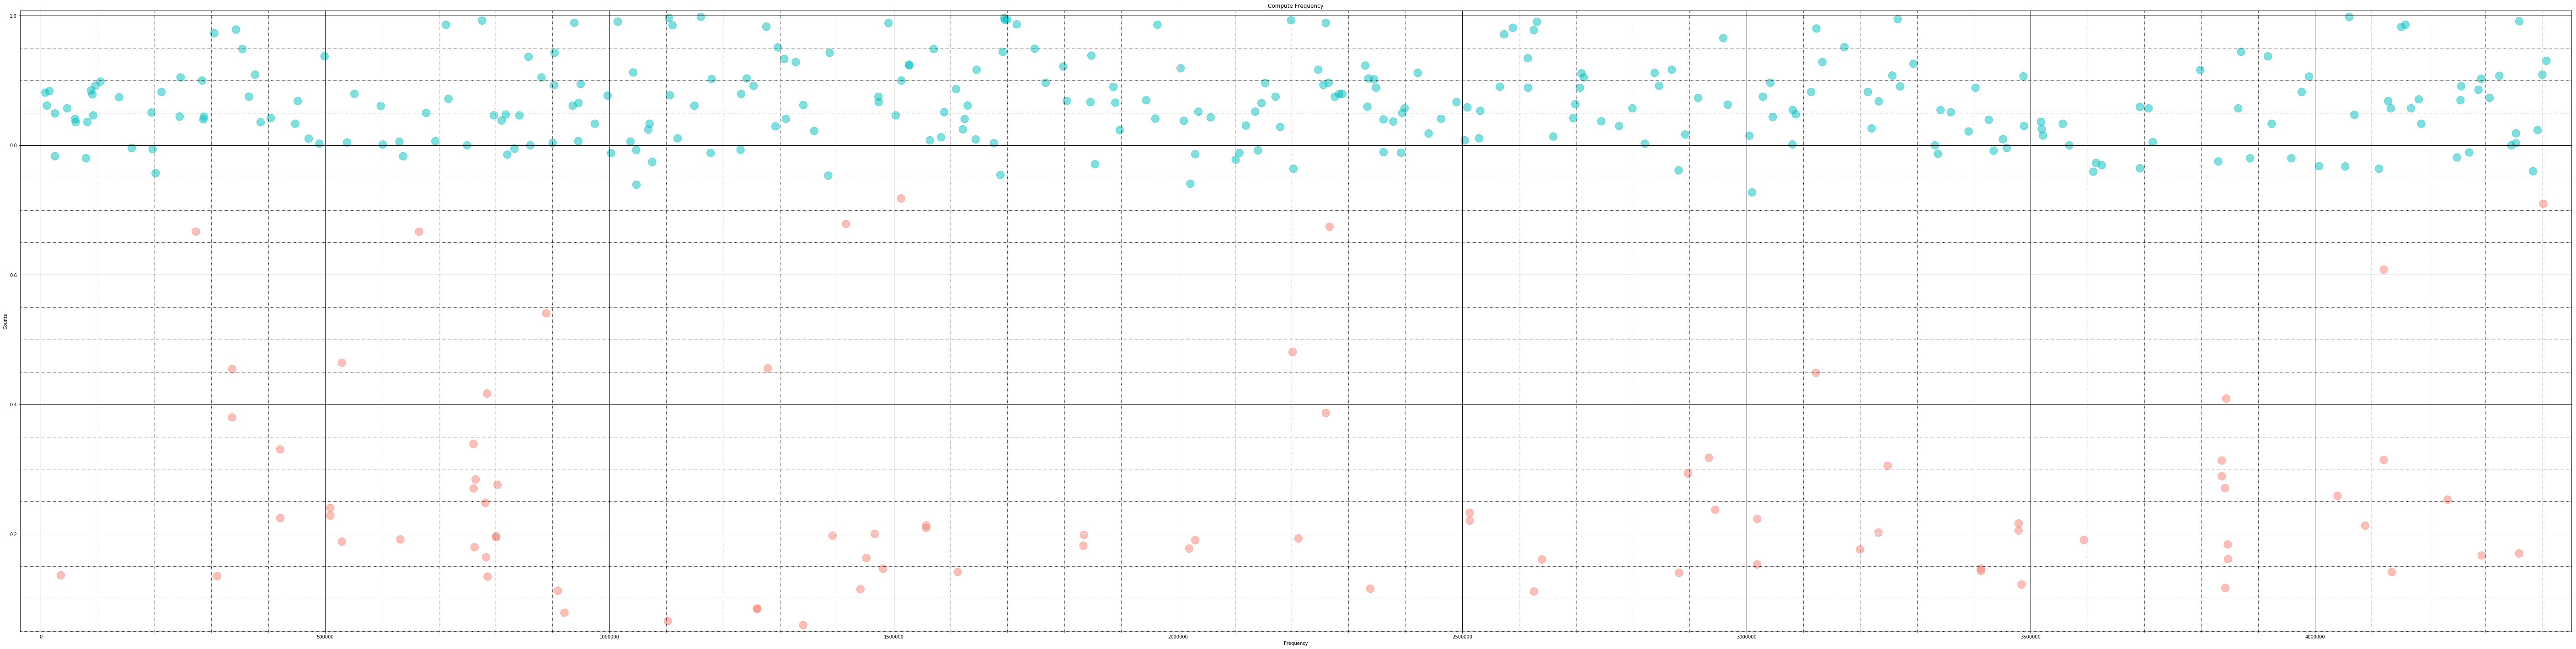

In [54]:
scatter_vcf_pos(PAIR180_dsf)

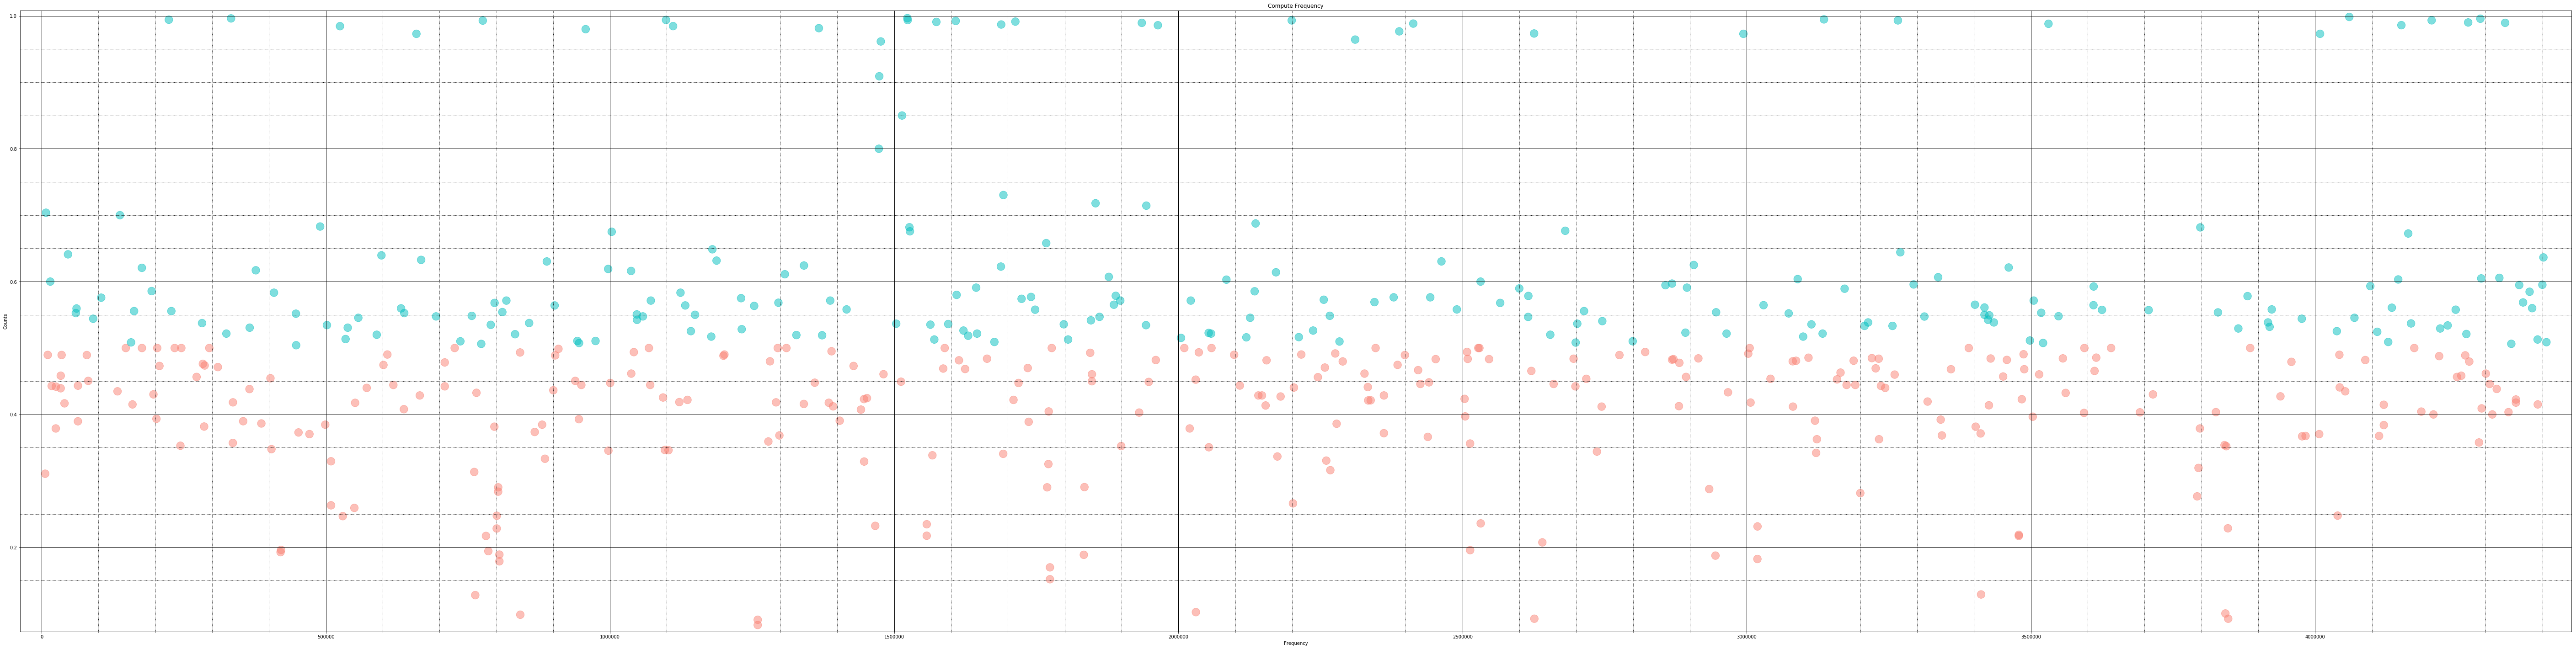

In [55]:
scatter_vcf_pos(PAIR150_dsf)

In [56]:
PAIR150_dsf['snp_right_distance'].dropna().describe()

count      966.000000
mean      4464.987578
std       4381.258736
min          1.000000
25%       1371.500000
50%       3121.500000
75%       6154.750000
max      28792.000000
Name: snp_right_distance, dtype: float64

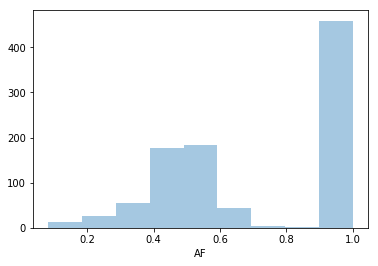

In [57]:
x = PAIR150_dsf['AF']
sns.distplot(x, kde=False, rug=False)

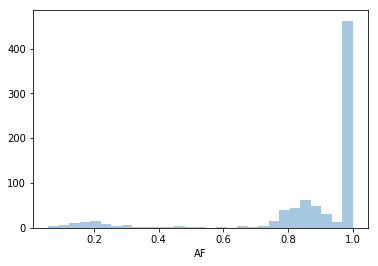

In [58]:
x = PAIR180_dsf['AF']
sns.distplot(x, kde=False, rug=False)

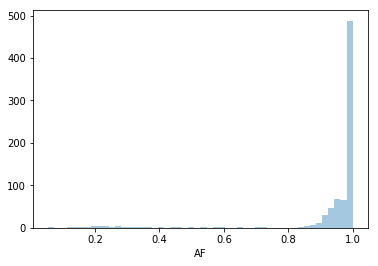

In [67]:
x = PAIR190_dsf['AF']
sns.distplot(x, kde=False, rug=False)

# Extract position by Allele Frequency

In [68]:
def split_df_mean(vcf_df):
    mean = vcf_df['AF'][vcf_df['AF'] < 1].mean(axis = 0)
    top_positions = vcf_df['POS'][(vcf_df['AF'] > mean) & (vcf_df['AF'] < 1)].tolist()
    bottom_positions = vcf_df['POS'][vcf_df['AF'] < mean].tolist()
    return top_positions, bottom_positions

## B = Burgos
## P = Paredes

In [69]:
B_file = "data/BURGOS89109_S9_L001__final.bam.snp.final"
P_file = "data/56850173_S1_L001__final.bam.snp.final"

In [70]:
B_final = import_to_pandas(B_file)
P_final = import_to_pandas(P_file)

In [71]:
B_pos = set(B_final.loc[:,0].tolist())
P_pos = set(P_final.loc[:,0].tolist())

In [72]:
B_exclusive = B_pos - P_pos
P_exclusive = P_pos - B_pos
Shared_position = P_pos & B_pos

print("B has %s unique positions\n\
P has %s unique positions\n\
Both share %s positions" % (len(B_exclusive) , len(P_exclusive), len(Shared_position)))

B has 317 unique positions
P has 354 unique positions
Both share 539 positions


In [73]:
print(len(B_exclusive))

317


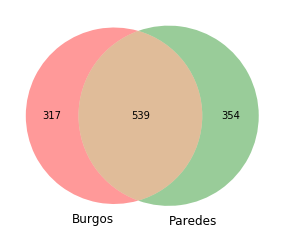

In [74]:
#venn2(subsets = (len(B_exclusive), len(P_exclusive), len(Shared_position)), set_labels = ('Burgos', 'Paredes'))
#plt.show()
venn2([B_pos, P_pos],  set_labels = ('Burgos', 'Paredes'))
plt.show()


# Check P80

In [75]:
top_P180, btm_P180 = split_df_mean(PAIR180_dsf)

In [76]:
print(len(top_P180))
print(len(btm_P180))

286
87


In [77]:
top_P180_set = set(top_P180)
btm_P180_set = set(btm_P180)

In [78]:
#Ven diagram with all (non exclusive snps in BURGOS)
#venn3([top_P180_set, btm_P180_set, B_pos], ('TOP', 'BTM', 'BURGOS'))
#plt.show()

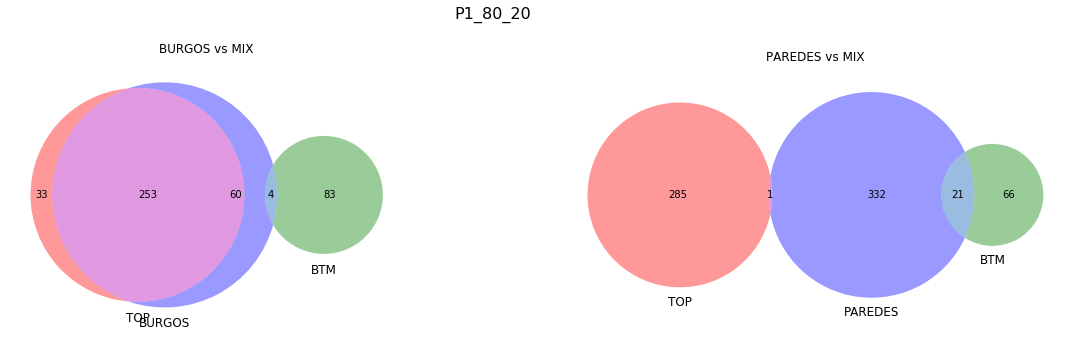

In [79]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title("BURGOS vs MIX")
v = venn3([top_P180_set, btm_P180_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P180_set, btm_P180_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(1, 2, 2)
plt.title("PAREDES vs MIX")
v2 = venn3([top_P180_set, btm_P180_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.suptitle('P1_80_20', fontsize=16, verticalalignment='bottom')

plt.show()

In [80]:
print(len(B_exclusive))

317


In [81]:
#Ven diagram with all (non exclusive snps in PAREDES)
#venn3([top_P180_set, btm_P180_set, P_pos], ('TOP', 'BTM', 'PAREDES'))
#plt.show()

# Check P90

In [82]:
top_P190, btm_P190 = split_df_mean(PAIR190_dsf)
top_P190_set = set(top_P190)
btm_P190_set = set(btm_P190)

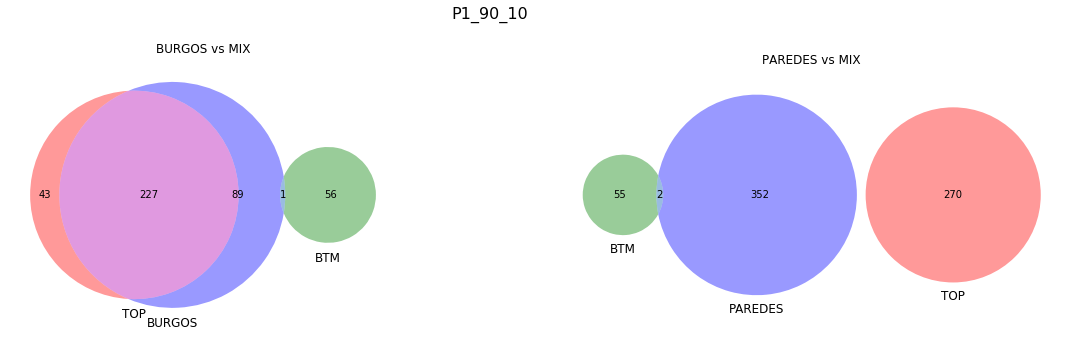

In [83]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title("BURGOS vs MIX")
v = venn3([top_P190_set, btm_P190_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P190_set, btm_P190_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(1, 2, 2)
plt.title("PAREDES vs MIX")
v2 = venn3([top_P190_set, btm_P190_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.suptitle('P1_90_10', fontsize=16, verticalalignment='bottom')

plt.show()

# Check P50

In [84]:
top_P150, btm_P150 = split_df_mean(PAIR150_dsf)
top_P150_set = set(top_P150)
btm_P150_set = set(btm_P150)

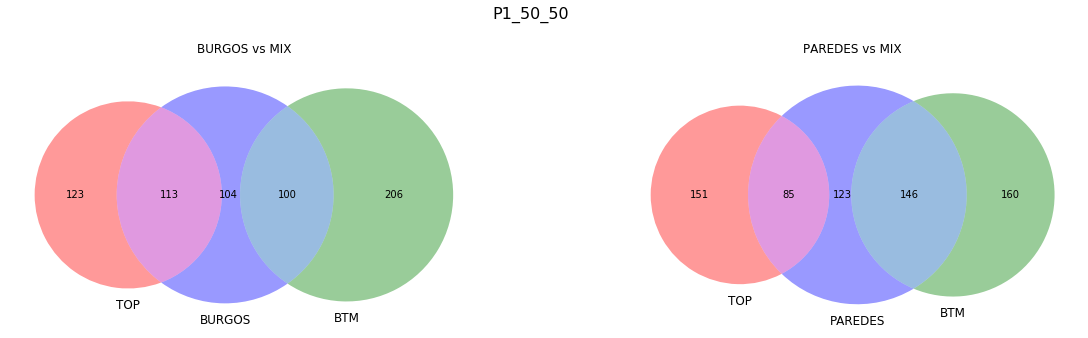

In [85]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title("BURGOS vs MIX")
v = venn3([top_P150_set, btm_P150_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P150_set, btm_P150_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(1, 2, 2)
plt.title("PAREDES vs MIX")
v2 = venn3([top_P150_set, btm_P150_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.suptitle('P1_50_50', fontsize=16, verticalalignment='bottom')

plt.show()

# Use SNPs filtered by Laura

In [86]:
snp_B_P_Laura = pd.read_excel("data/SNPs_diferenciales_burgos_paredes.xlsx")

In [87]:
snp_B_P_Laura.head()

Position  56850173_S1_L001__final.bam.snp.final  \
0      1977                                      0   
1      6140                                      1   
2      7585                                      0   
3      9304                                      0   
4     10741                                      0   

   BURGOS89109_S9_L001__final.bam.snp.final  Sum  
0                                         1    1  
1                                         0    1  
2                                         1    1  
3                                         1    1  
4                                         1    1

In [88]:
B_exclusive_L = snp_B_P_Laura['Position'][snp_B_P_Laura['BURGOS89109_S9_L001__final.bam.snp.final'] == 1].tolist()
P_exclusive_L = snp_B_P_Laura['Position'][snp_B_P_Laura['56850173_S1_L001__final.bam.snp.final'] == 1].tolist()
B_exclusive_L_set = set(B_exclusive_L)
P_exclusive_L_set = set(P_exclusive_L)

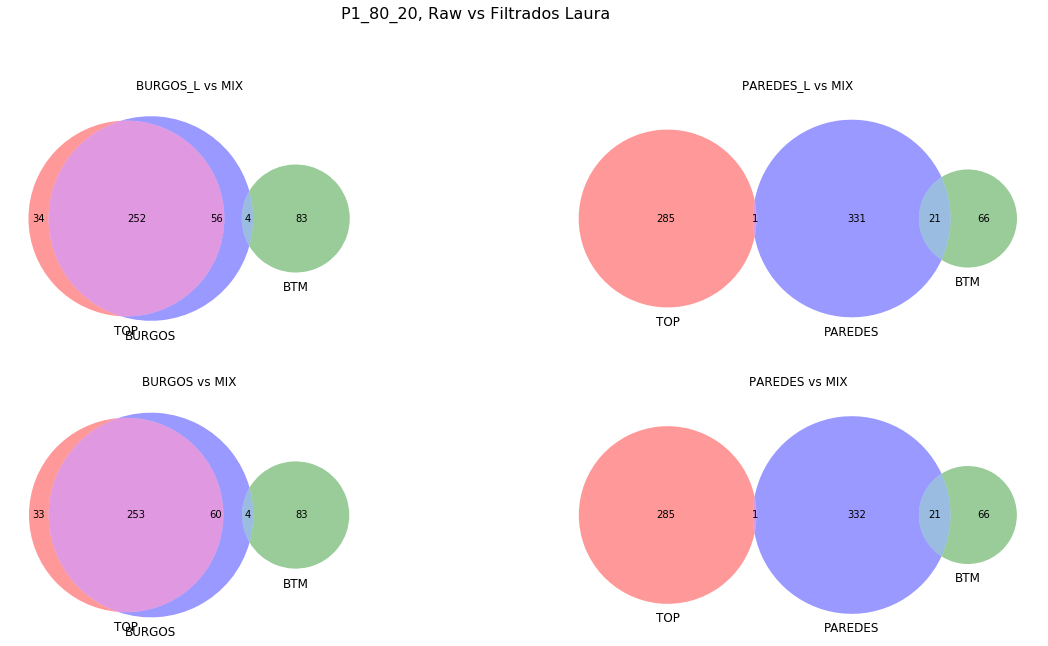

In [89]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.title("BURGOS_L vs MIX")
v = venn3([top_P180_set, btm_P180_set, B_exclusive_L_set], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P150_set, btm_P150_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(2, 2, 2)
plt.title("PAREDES_L vs MIX")
v2 = venn3([top_P180_set, btm_P180_set, P_exclusive_L_set], set_labels = ('TOP', 'BTM', 'PAREDES'))


plt.subplot(2, 2, 3)
plt.title("BURGOS vs MIX")
v = venn3([top_P180_set, btm_P180_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P180_set, btm_P180_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(2, 2, 4)
plt.title("PAREDES vs MIX")
v2 = venn3([top_P180_set, btm_P180_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))


plt.suptitle('P1_80_20, Raw vs Filtrados Laura', fontsize=16, verticalalignment='bottom')

plt.savefig(os.path.join('img', 'P1_80_20_RAW_LAU.svg'), format="svg")
#plt.show()

# FINAL COMPARISON

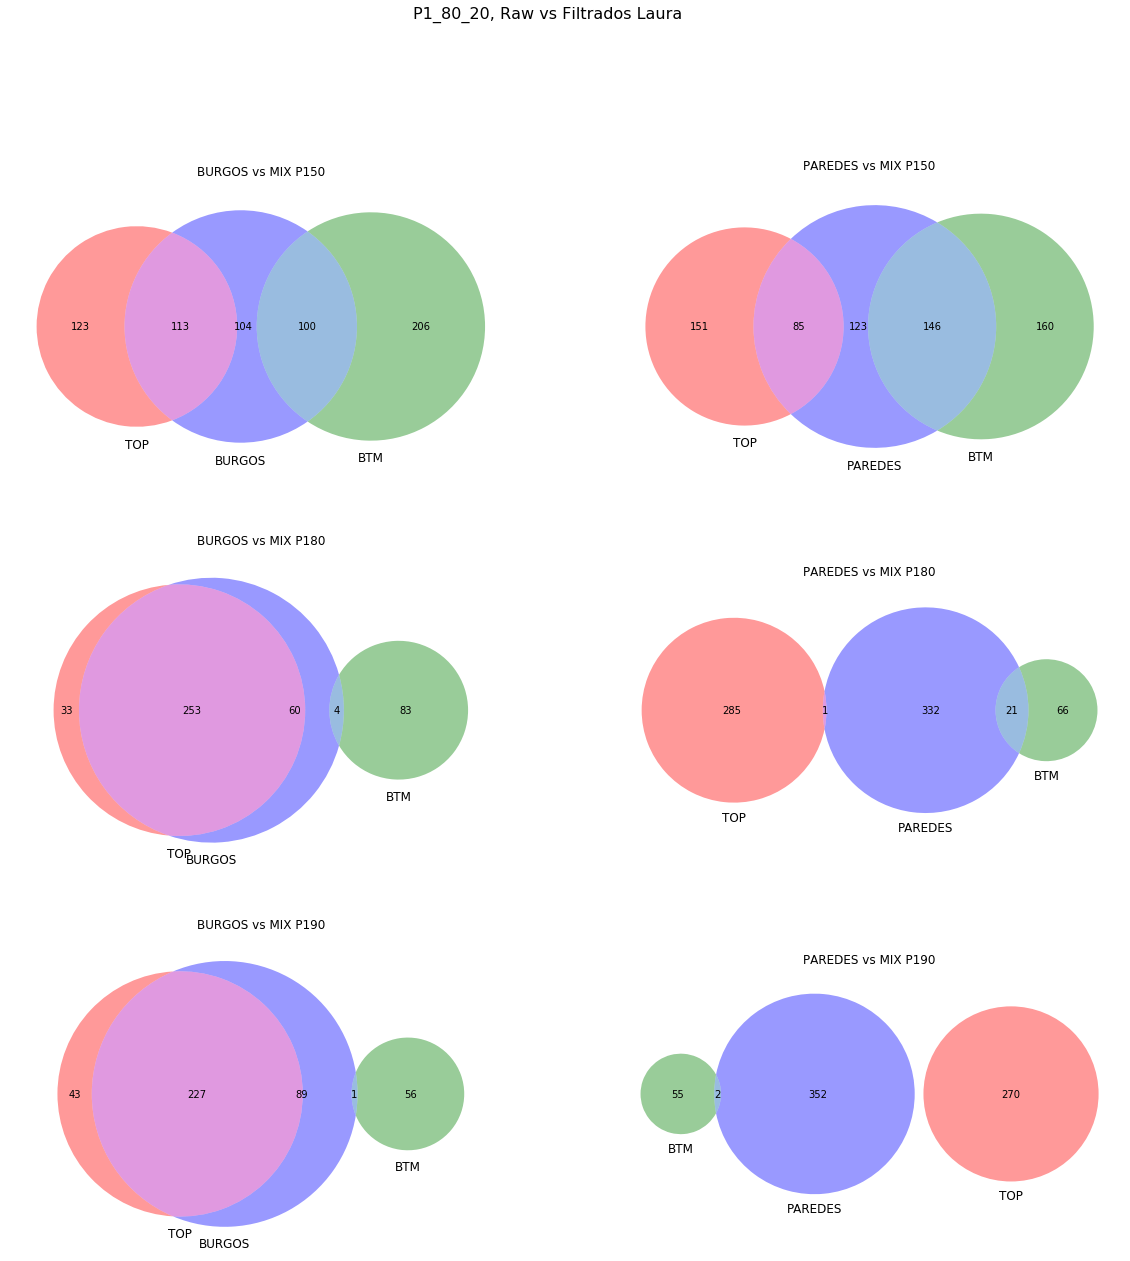

In [90]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,20))

plt.subplot(3, 2, 1)
plt.title("BURGOS vs MIX P150")
v = venn3([top_P150_set, btm_P150_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P150_set, btm_P150_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(3, 2, 2)
plt.title("PAREDES vs MIX P150")
v2 = venn3([top_P150_set, btm_P150_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))


plt.subplot(3, 2, 3)
plt.title("BURGOS vs MIX P180")
v = venn3([top_P180_set, btm_P180_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P180_set, btm_P180_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(3, 2, 4)
plt.title("PAREDES vs MIX P180")
v2 = venn3([top_P180_set, btm_P180_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.subplot(3, 2, 5)
plt.title("BURGOS vs MIX P190")
v = venn3([top_P190_set, btm_P190_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P180_set, btm_P180_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(3, 2, 6)
plt.title("PAREDES vs MIX P190")
v2 = venn3([top_P190_set, btm_P190_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))
plt.suptitle('P1_80_20, Raw vs Filtrados Laura', fontsize=16, verticalalignment='bottom')

plt.savefig(os.path.join('img', 'P1_ALL.svg'), format="svg")
#plt.show()

# Check mixed linage 

In [91]:
def split_df_mean_todict(vcf_df):
    mean = vcf_df['AF'][vcf_df['AF'] < 1].mean(axis = 0)
    top_positions = vcf_df[(vcf_df['AF'] > mean) & (vcf_df['AF'] < 1)]
    top_positions_dict = top_positions.set_index('POS')['ALT'].to_dict()
    bottom_positions = vcf_df[vcf_df['AF'] < mean]
    bottom_positions_dict = bottom_positions.set_index('POS')['ALT'].to_dict()
    return top_positions_dict, bottom_positions_dict

In [92]:
PAIR180_dict = PAIR180_dsf.set_index('POS')['ALT'].to_dict()
PAIR190_dict = PAIR190_dsf.set_index('POS')['ALT'].to_dict()
PAIR150_dict = PAIR150_dsf.set_index('POS')['ALT'].to_dict()

KeyError: 'ALT'

In [396]:
get_lineage_coll(PAIR180_dict)
get_lineage_coll(PAIR190_dict)
get_lineage_coll(PAIR150_dict)

This samples belongs to linage 4
This samples belongs to linage 4
This samples belongs to linage 4


'4'

In [397]:
top_P180_dict, btm_P180_dict = split_df_mean_todict(PAIR180_dsf)
top_P190_dict, btm_P190_dict = split_df_mean_todict(PAIR190_dsf)
top_P150_dict, btm_P150_dict = split_df_mean_todict(PAIR150_dsf)
get_lineage_coll(top_P180_dict)
get_lineage_coll(top_P190_dict)
get_lineage_coll(top_P150_dict)
get_lineage_coll(btm_P180_dict)
get_lineage_coll(btm_P190_dict)
get_lineage_coll(btm_P150_dict)

This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown


'unknown'

In [401]:
get_resistance_snp(PAIR180_dict)
get_resistance_snp(PAIR190_dict)
get_resistance_snp(PAIR150_dict)

This strain has those resistance positions:pyrazinamide (PZA)
This strain has those resistance positions:pyrazinamide (PZA)
This strain has those resistance positions:pyrazinamide (PZA)


['pyrazinamide (PZA)']

In [402]:
get_resistance_snp(top_P180_dict)
get_resistance_snp(top_P190_dict)
get_resistance_snp(top_P150_dict)
get_resistance_snp(btm_P180_dict)
get_resistance_snp(btm_P190_dict)
get_resistance_snp(btm_P150_dict)

This strain has those resistance positions:pyrazinamide (PZA)
This strain has those resistance positions:pyrazinamide (PZA)
This strain has those resistance positions:pyrazinamide (PZA)
This strain has those resistance positions:
This strain has those resistance positions:
This strain has those resistance positions:


[]